In [1]:
import os

#add the root directory
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from loader import *
from utils import Species
import h5py
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle
import io

from datetime import datetime

from ANN_regression import *
from torchdiffeq import odeint
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import FancyArrowPatch, Ellipse
import matplotlib.lines as mlines

from matplotlib.legend_handler import HandlerBase
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FixedLocator, NullFormatter

import logging
logging.disable(logging.CRITICAL)

# Supplementary material: comparison of the complete/original optimized PV vs. the sparse optimized PV for the A posteriori analysis

<h3> Prepare all the datasets

In [3]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"
regression_modelname_optimized_sparse = "Optimized_Tr0D-2s_s2_sparse5_2026-02-03_15h52_s7"   #handles negative values with abs, 300k epo without minibatching
regression_modelname_optimized_complete = "Optimized_Tr0D-2s_s2_2026-01-20_16h11_s7" #handles negative values with abs, 300k epo without minibatching

regression_full_modelname_optimized_sparse = "Optimized_full_Tr0D-2s_s2_sparse5_2026-02-03_14h58" #With rectangular manifold
regression_full_modelname_optimized_complete = "Optimized_full_Tr0D-2s_s2_2026-01-26_16h02" #rectangular manifold now

path_regression_model = "paper/models/"

## Define the global datasets

In [4]:
#create all the datasets
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)

---
<h3> Complete optimized PV: PV source term model - f-PV to PV source

In [5]:
#Load the ANN closure model

torch.serialization.default_restore_location = lambda storage, loc: storage
with open(f'{path_regression_model}{regression_modelname_optimized_complete}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_optimized_complete = loaded_dict["mins_input"]
maxs_input_optimized_complete = loaded_dict["maxs_input"]
mins_output_optimized_complete = loaded_dict["mins_output"]
maxs_output_optimized_complete = loaded_dict["maxs_output"]

log_PVsource_optimized_complete = loaded_dict["log_PVsource"]

epsilon = loaded_dict["epsilon"]
log_transform_opt = loaded_dict["log transformation"]
scaledManifold_opt = loaded_dict["scaled manifold"]

#signPV_inverted = loaded_dict["signPV_inverted"]
PV_optimized_complete_source_train_min = loaded_dict["PV_optimized_source_train_min"]
PV_optimized_complete_source_train_max = loaded_dict["PV_optimized_source_train_max"]

model_regression_optimized_complete = ANN_regression(**model_params)
model_regression_optimized_complete.load_state_dict(torch.load(f"{path_regression_model}{regression_modelname_optimized_complete}_model.pth", weights_only=False))

filename_PV_model = loaded_dict["filename_PV_model"]

filename_metadata = filename_PV_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model_complete = loader.metadata["Training_id"]
PV_model_complete = loader.loadModel()

weight_inversion = loaded_dict["weight_inversion"]
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        PV_model_complete.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

def inverse_symlog(x_prime, threshold):
    return np.sign(x_prime) * threshold * (10 ** np.abs(x_prime) - 1)

In [6]:
prediction_test_trajectories_optimized_complete = []

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        if(scaledManifold_opt):
            PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())
            #print(PV_optimized_test)

        f_PV_optimized_complete_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        f_PV_optimized_complete_test = torch.tensor(f_PV_optimized_complete_test)
        f_PV_optimized_complete_test_scaled =  (f_PV_optimized_complete_test - mins_input_optimized_complete) / (maxs_input_optimized_complete - mins_input_optimized_complete) - 0.5
         
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    PV_optimized_complete_source_test_predicted = model_regression_optimized_complete(f_PV_optimized_complete_test_scaled)
    PV_optimized_complete_source_test_predicted =  (PV_optimized_complete_source_test_predicted+1) /2 * (maxs_output_optimized_complete - mins_output_optimized_complete) + mins_output_optimized_complete
    PV_optimized_complete_source_test_predicted = PV_optimized_complete_source_test_predicted.detach().numpy()
    if(log_PVsource_optimized_complete):
        if(log_transform_opt == "continuous-symlog"):
            PV_optimized_complete_source_test_predicted = inverse_symlog(PV_optimized_complete_source_test_predicted, epsilon)
        elif(log_transform_opt == "log"):
            PV_optimized_complete_source_test_predicted = 10**PV_optimized_complete_source_test_predicted
    prediction_test_trajectories_optimized_complete.append(PV_optimized_complete_source_test_predicted)
    MSE_optimized_test = mean_squared_error(PV_optimized_source_test, PV_optimized_complete_source_test_predicted)

    print(f"MSE of optimized PV for test trajectory {i}: {MSE_optimized_test}")

MSE of optimized PV for test trajectory 0: 11618748.91063428
MSE of optimized PV for test trajectory 1: 13615689.176194813
MSE of optimized PV for test trajectory 2: 14025375.457203146
MSE of optimized PV for test trajectory 3: 34290327.58611162
MSE of optimized PV for test trajectory 4: 37167353.81558447
MSE of optimized PV for test trajectory 5: 27514168.258930765
MSE of optimized PV for test trajectory 6: 7672466.9451405965
MSE of optimized PV for test trajectory 7: 25926392.74041629
MSE of optimized PV for test trajectory 8: 109331268.67131251
MSE of optimized PV for test trajectory 9: 261377148.78421092


C:\Windows\Temp\ipykernel_27532\2711741905.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


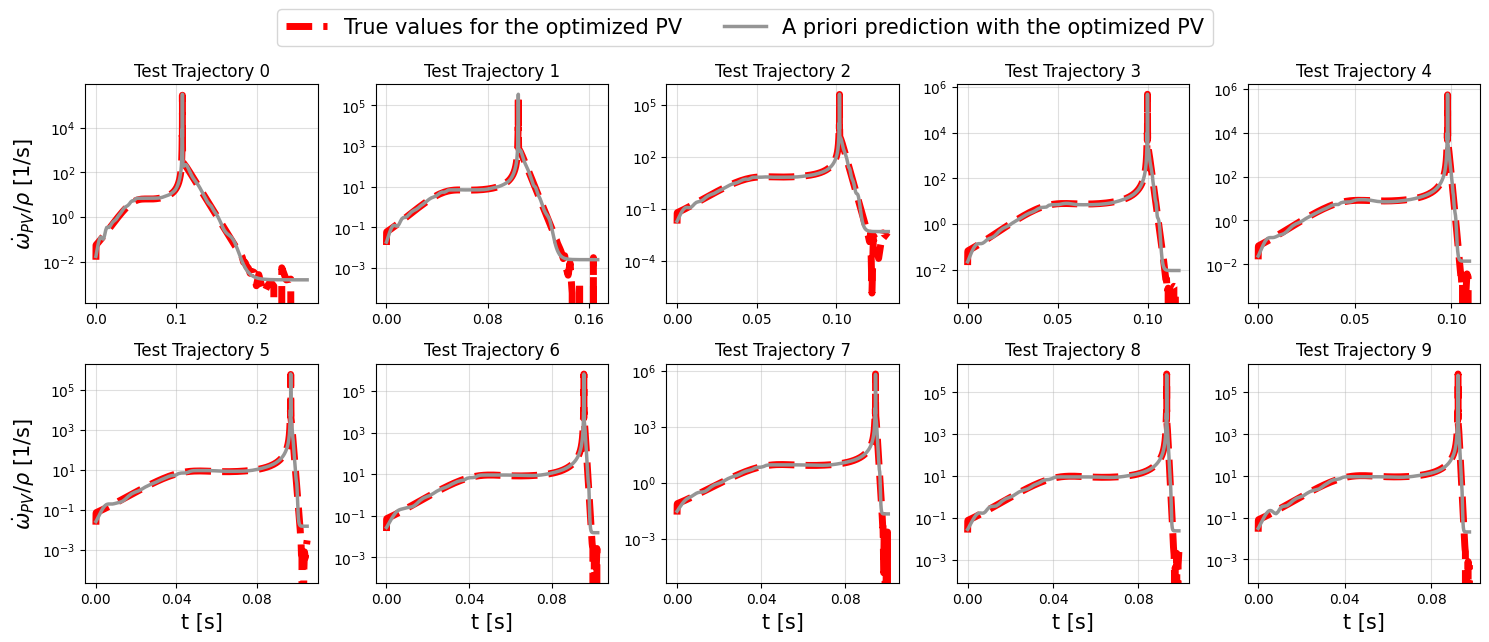

In [ ]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"
name = f"Apriori_ANN_{regression_modelname_optimized_complete}.png"
namePdf = f"Apriori_ANN_{regression_modelname_optimized_complete}.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

greys = cm.get_cmap('Greys')

for i in range(num_test_trajectories):
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    ax.plot(test_trajectory_time, PV_optimized_source_test, label="True values for the optimized PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time, prediction_test_trajectories_optimized_complete[i], label="A priori prediction with the optimized PV", color = greys(0.5), linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

---
<h3> Complete optimized PV: Evolve the PV over time

In [7]:
class ODEOptimized_complete(torch.nn.Module):

    def __init__(self, min_max_PV):
        super().__init__()
        self.min_PV = min_max_PV[0]
        self.max_PV = min_max_PV[1]

    def forward(self, t, y):
        y_scaled = y.clone() #avoid in place changes
        if scaledManifold_opt:
            y_scaled[1] = (y_scaled[1] - self.min_PV)/(self.max_PV - self.min_PV)
                
        
        #print(y)
        
        f_PV = (y_scaled-mins_input_optimized_complete) / (maxs_input_optimized_complete - mins_input_optimized_complete) - 0.5
        PV_source_predicted = model_regression_optimized_complete(f_PV)
        PV_source_predicted = (PV_source_predicted+1) /2 * (maxs_output_optimized_complete - mins_output_optimized_complete) + mins_output_optimized_complete
        
        if(log_transform_opt == "continuous-symlog"):
            PV_optimized_source_test_predicted = inverse_symlog(PV_source_predicted, epsilon)
        elif(log_transform_opt == "log"):
            PV_optimized_source_test_predicted = 10**PV_source_predicted

        zero = torch.tensor([[0.0]], dtype=PV_optimized_source_test_predicted.dtype, device=PV_optimized_source_test_predicted.device)
        f_PV_source_predicted = torch.cat((zero, PV_optimized_source_test_predicted), dim=1) #add a zero for the mixture fraction
        

        return f_PV_source_predicted.squeeze()

In [8]:
idx_start_simulation = 0
list_simulations_optimized_complete = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Predicted")

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_complete_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        f_PV_optimized_complete_test = np.hstack((np.full(PV_optimized_complete_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_complete_test.reshape(-1,1)))
        f_PV_optimized_complete_test = torch.from_numpy(f_PV_optimized_complete_test).clone().detach()

        
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_optimized_complete_test[idx_start_simulation,:]

    t_coordinates = test_trajectory_time[idx_start_simulation:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    
    ODEOptimized_instance = ODEOptimized_complete([PV_optimized_complete_test.min(), PV_optimized_complete_test.max()])
    numerical_solution_optimized_complete = odeint(ODEOptimized_instance, initial_condition, t_coordinates)#, method="rk4")
    list_simulations_optimized_complete.append(numerical_solution_optimized_complete) 

    MSE_optimized_complete_test_simulation = mean_squared_error(PV_optimized_complete_test[idx_start_simulation:], numerical_solution_optimized_complete.squeeze()[:,1].detach().numpy())

    print(f"MSE for test trajectory {i}: {MSE_optimized_complete_test_simulation}")

Predicted
MSE for test trajectory 0: 7.877221372146799
MSE for test trajectory 1: 13.926456565267479
MSE for test trajectory 2: 22.04926003790187
MSE for test trajectory 3: 26.767032670272737
MSE for test trajectory 4: 28.78203830412195
MSE for test trajectory 5: 25.480835140509917
MSE for test trajectory 6: 13.71512018809177
MSE for test trajectory 7: 18.219914532768392
MSE for test trajectory 8: 29.585384861673223
MSE for test trajectory 9: 34.042591660933134


Use the MSE to quantitatively assess the quality of the simulationsn take the average MSE?

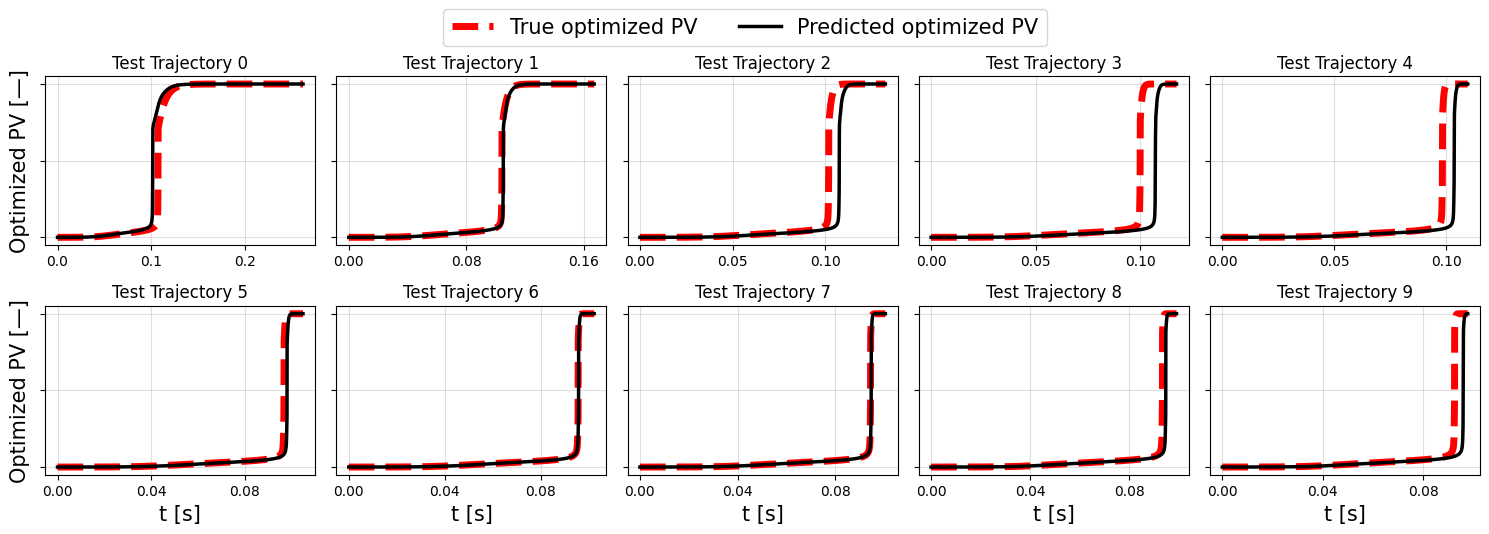

In [17]:
save = True
zoom = False
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"


num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]

    PV_min = PV_optimized_test[idx_start_simulation:].min()
    PV_max = PV_optimized_test[idx_start_simulation:].max()

    #-(list_simulations_optimized[i][:,1]-PV_min)/(PV_max - PV_min)+1

    if(zoom):
        ##############################################
        # Get the first and last index of the ignition
        ##############################################

        H2O_array = test_trajectory["H2O"].to_numpy()
        
        max_val = H2O_array.max()
        min_perc = 0.0028
        max_perc = 0.999
        lower_threshold = min_perc * max_val
        upper_threshold = max_perc * max_val

        idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
        idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

        ax.plot(test_trajectory_time[idx_1:idx_99], -(PV_optimized_test[idx_1:idx_99]-PV_min)/(PV_max - PV_min)+1, label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_1:idx_99], -(list_simulations_optimized_complete[i][idx_1:idx_99,1]-PV_min)/(PV_max - PV_min)+1, label="Predicted optimized PV", color = "k", linewidth = 2.5) #idx_end-idx_start_simulation
    else:
        ax.plot(test_trajectory_time[idx_start_simulation:], (PV_optimized_test[idx_start_simulation:]-PV_min)/(PV_max - PV_min), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_optimized_complete[i][:,1].detach().numpy()-PV_min)/(PV_max - PV_min), label="Predicted optimized PV", color = "k", linewidth = 2.5) #idx_end-idx_start_simulation
    
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

    ax.grid(True, linestyle='-', alpha=0.4)

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

name = f"Sparse vs complete optimized {id_model_complete} - ANN {regression_modelname_optimized_complete}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.png"
namePdf = f"Sparse vs complete optimized {id_model_complete} - ANN {regression_modelname_optimized_complete}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.pdf"

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

<h3> Run the a posteriori simulation longer

In [9]:
list_simulations_optimized_complete_ext = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Predicted")

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_complete_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        f_PV_optimized_complete_test = np.hstack((np.full(PV_optimized_complete_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_complete_test.reshape(-1,1)))
        f_PV_optimized_complete_test = torch.from_numpy(f_PV_optimized_complete_test).clone().detach()

        
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_optimized_complete_test[0,:]

    t_coordinates = test_trajectory_time[0:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    deltaTime = t_coordinates[-1] - t_coordinates[-2]

    last_value = t_coordinates[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        t_coordinates = torch.cat((t_coordinates, extension))
    
    ODEOptimized_complete_instance = ODEOptimized_complete([PV_optimized_complete_test.min(), PV_optimized_complete_test.max()])
    numerical_solution_optimized_complete = odeint(ODEOptimized_complete_instance, initial_condition, t_coordinates)#, method="rk4")
    list_simulations_optimized_complete_ext.append(numerical_solution_optimized_complete) 

Predicted


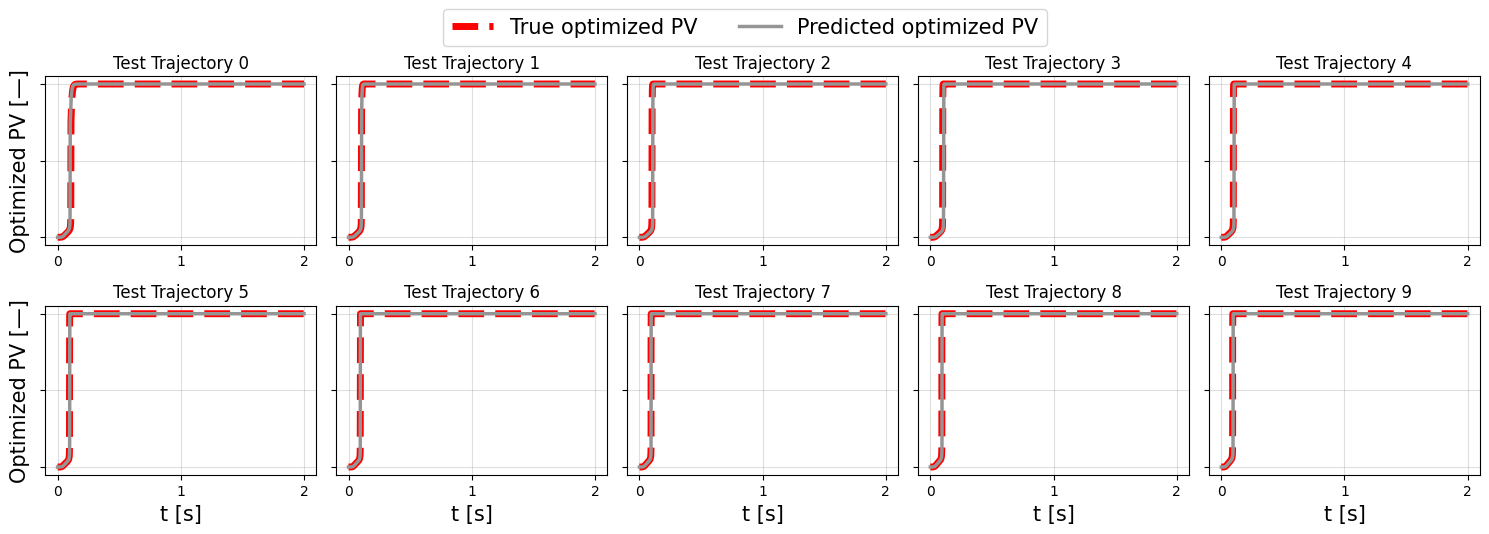

In [19]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"
name = f"Sparse vs complete optimized - ANN {regression_modelname_optimized_complete}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.png"
namePdf = f"Sparse vs complete optimized - ANN {regression_modelname_optimized_complete}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_complete_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_optimized_complete_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_optimized_test
        PV_optimized_complete_test_ext = np.vstack((PV_optimized_complete_test, extension)) #concatenate the extension with the original value
    
    min_PV = PV_optimized_complete_test.min()
    max_PV = PV_optimized_complete_test.max()
    
    ax = axes[i]
    ax.plot(test_trajectory_time_ext, (PV_optimized_complete_test_ext-min_PV)/(max_PV-min_PV), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
    ax.plot(test_trajectory_time_ext, (list_simulations_optimized_complete_ext[i].squeeze()[:,1].detach().numpy()-min_PV)/(max_PV-min_PV), label="Predicted optimized PV", color = greys(0.5), linewidth = 2.5) #idx_end-idx_start_simulation
    ax.set_title(f"Test Trajectory {i}")
    ax.set_xticks([0, 1 , 2])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

    ax.grid(True, linestyle='-', alpha=0.4)

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

In [10]:
def ignition_time_difference(time_array, pv_true, pv_pred, threshold=0.99):
    """
    Compute the time difference between true and predicted PV ignition times.
    
    Parameters
    ----------
    time_array : np.ndarray
        1D array of time values.
    pv_true : np.ndarray
        1D array of true PV values (same length as time_array).
    pv_pred : np.ndarray
        1D array of predicted PV values (same length as time_array).
    threshold : float, optional
        The PV threshold for ignition (default: 0.99).
    
    Returns
    -------
    float or None
        The time difference (predicted - true) when both trajectories reach
        the threshold. Returns None if either trajectory never reaches it.
    """
    # Find first index where true PV >= threshold
    true_idx = np.argmax(pv_true >= threshold) if np.any(pv_true >= threshold) else None
    # Find first index where predicted PV >= threshold
    pred_idx = np.argmax(pv_pred >= threshold) if np.any(pv_pred >= threshold) else None

    if true_idx is None or pred_idx is None:
        return None  # one of them never reaches threshold

    true_time = time_array[true_idx]
    pred_time = time_array[pred_idx]

    return np.round(pred_time - true_time, 3), np.round(np.abs(pred_time - true_time)/pred_time*100, 3)

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_optimized_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
        PV_optimized_complete_test_ext = np.vstack((PV_optimized_test, extension)) #concatenate the extension with the original value

    min_PV = PV_optimized_complete_test_ext.min()
    max_PV = PV_optimized_complete_test_ext.max()

    true_PV_norm = (PV_optimized_complete_test_ext - min_PV) / (max_PV - min_PV)
    pred_PV_norm = (list_simulations_optimized_complete_ext[i].squeeze()[:,1].detach().numpy() - min_PV) / (max_PV - min_PV)

    # Compute ignition time difference
    dt, perc = ignition_time_difference(np.array(test_trajectory_time_ext), true_PV_norm, pred_PV_norm)
    print(f"Ignition time difference of traj {i}:", dt, f"s - {perc}%")

Ignition time difference of traj 0: -0.006 s - 5.128%
Ignition time difference of traj 1: 0.001 s - 0.799%
Ignition time difference of traj 2: 0.006 s - 5.305%
Ignition time difference of traj 3: 0.008 s - 6.896%
Ignition time difference of traj 4: 0.005 s - 5.163%
Ignition time difference of traj 5: 0.001 s - 1.333%
Ignition time difference of traj 6: 0.0 s - 0.154%
Ignition time difference of traj 7: 0.0 s - 0.245%
Ignition time difference of traj 8: 0.001 s - 1.418%
Ignition time difference of traj 9: 0.004 s - 3.893%


<h3> Reconstruction to the full state space

In [11]:
#Load the model

with open(f'{path_regression_model}{regression_full_modelname_optimized_complete}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_full_optimized_complete = loaded_dict["mins_input"]
maxs_input_full_optimized_complete = loaded_dict["maxs_input"]
mins_output_full_optimized_complete = loaded_dict["mins_output"]
maxs_output_full_optimized_complete = loaded_dict["maxs_output"]

scaledManifold_full_opt_complete = loaded_dict["scaleManifold"]

neuron_layers = loaded_dict["neuron_layers"]
max_epo = loaded_dict["max_epo"]

model_regression_full_optimized_complete = ANN_regression(**model_params)
model_regression_full_optimized_complete.load_state_dict(torch.load(f"{path_regression_model}{regression_full_modelname_optimized_complete}_model.pth", weights_only=False))

print(f"Final MSE: {loaded_dict['final validation error']}")

Output_species = loaded_dict["Output_species"]

for i in range(10):
    f_PV_array = list_simulations_optimized_complete[i][:].clone()


    if(scaledManifold_full_opt_complete):
        with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
        f_PV_array[:, 1] = (f_PV_array[:, 1] - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    f_PV_array_scaled = (f_PV_array - mins_input_full_optimized_complete)/(maxs_input_full_optimized_complete - mins_input_full_optimized_complete) - 0.5
    prediction_optimized_complete = model_regression_full_optimized_complete(f_PV_array_scaled)

Final MSE: 6.41537521177016e-06


<hr style="border:2px solid gray">
<h3> Sparse optimized PV: PV source term model - f-PV to PV source

In [12]:
#Load the ANN closure model

torch.serialization.default_restore_location = lambda storage, loc: storage
with open(f'{path_regression_model}{regression_modelname_optimized_sparse}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_optimized_sparse = loaded_dict["mins_input"]
maxs_input_optimized_sparse = loaded_dict["maxs_input"]
mins_output_optimized_sparse = loaded_dict["mins_output"]
maxs_output_optimized_sparse = loaded_dict["maxs_output"]

log_PVsource_optimized_sparse = loaded_dict["log_PVsource"]

epsilon = loaded_dict["epsilon"]
log_transform_opt = loaded_dict["log transformation"]
scaledManifold_opt_sparse = loaded_dict["scaled manifold"]

#signPV_inverted = loaded_dict["signPV_inverted"]
PV_optimized_sparse_source_train_min = loaded_dict["PV_optimized_source_train_min"]
PV_optimized_sparse_source_train_max = loaded_dict["PV_optimized_source_train_max"]

model_regression_optimized_sparse = ANN_regression(**model_params)
model_regression_optimized_sparse.load_state_dict(torch.load(f"{path_regression_model}{regression_modelname_optimized_sparse}_model.pth", weights_only=False))

filename_PV_model = loaded_dict["filename_PV_model"]

filename_metadata = filename_PV_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model_sparse = loader.metadata["Training_id"]
PV_model_sparse = loader.loadModel()

weight_inversion = loaded_dict["weight_inversion"]
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        PV_model_sparse.encoder_species.weight.mul_(-1)

#############################
###### Sparsify the PV ######
#############################

nbr_input_species = 19
nbr_species_sparse = 5

order_species_removed = []
dataset_type = "autoignition"
path_state = path_data + f"Xu-state-space-{dataset_type}.csv"
if(dataset_type == "low"):
    header_data = None
else:
    header_data = "infer"

species = Species(path_data)
list_all_species = species.get_list_species()
list_input_species = [item for idx, item in enumerate(list_all_species) if idx not in idx_species_removed]

print(f"number input species: {nbr_input_species}")

for i in range(nbr_input_species - nbr_species_sparse): #nbr_input_species):

    #Update the model with the threshold

    final_weights = copy.deepcopy(PV_model_sparse.encoder_species.weight.detach().numpy()[0])

    if(PV_model_sparse.auto_scaling):
        final_weights *= PV_model_sparse.scaling_weights.detach().numpy()

    #get index spcies removed
    my_species = Species(path_data)
    
    list_species = my_species.get_list_species()
    for index in sorted(idx_species_removed, reverse=True):
        list_species.pop(index)

    #get mass fractions of species
    state_space = pd.read_csv(path_state, header = header_data)
    state_space = state_space.drop(state_space.columns[idx_species_removed], axis=1)
    state_space_matrix = state_space.to_numpy()

    wi_Yi = state_space_matrix*np.abs(final_weights) #|w_i|*Y_i
    max_wi_Yi = np.max(wi_Yi, axis = 0) #take max of every species

    #selection of values greater than zero
    #CHECK that none of the weights in the PV is already zero!
    mask = max_wi_Yi > 0

    #Find the index with the minimum max wi Yi which is not zero
    index_species_min_max_wi_Yi = np.argmin(max_wi_Yi[mask])

    #Get the index back in the original array
    index_species_min_max_wi_Yi = np.where(mask)[0][index_species_min_max_wi_Yi]
    
    with torch.no_grad():
        PV_model_sparse.encoder_species.weight[0,index_species_min_max_wi_Yi] = 0
        order_species_removed.append(list_input_species[index_species_min_max_wi_Yi])

final_weights = copy.deepcopy(PV_model_sparse.encoder_species.weight.detach().numpy()[0])
print(final_weights)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

number input species: 19
[  0.         -38.2823184    5.83405763   0.           0.
 136.89436503   0.           0.         -15.26686244   0.
   0.           0.           0.           0.          11.50584106
   0.           0.           0.           0.        ]


In [13]:
prediction_test_trajectories_optimized_sparse = []

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_sparse_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        if(scaledManifold_opt):
            PV_optimized_sparse_test = (PV_optimized_sparse_test - PV_optimized_sparse_test.min())/(PV_optimized_sparse_test.max() - PV_optimized_sparse_test.min())
            #print(PV_optimized_test)

        f_PV_optimized_sparse_test = np.hstack((np.full(PV_optimized_sparse_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_sparse_test.reshape(-1,1)))
        f_PV_optimized_sparse_test = torch.tensor(f_PV_optimized_sparse_test)
        f_PV_optimized_sparse_test_scaled =  (f_PV_optimized_sparse_test - mins_input_optimized_sparse) / (maxs_input_optimized_sparse - mins_input_optimized_sparse) - 0.5
         
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    PV_optimized_sparse_source_test_predicted = model_regression_optimized_sparse(f_PV_optimized_sparse_test_scaled)
    PV_optimized_sparse_source_test_predicted =  (PV_optimized_sparse_source_test_predicted+1) /2 * (maxs_output_optimized_sparse - mins_output_optimized_sparse) + mins_output_optimized_sparse
    PV_optimized_sparse_source_test_predicted = PV_optimized_sparse_source_test_predicted.detach().numpy()
    if(log_PVsource_optimized_sparse):
        if(log_transform_opt == "continuous-symlog"):
            PV_optimized_sparse_source_test_predicted = inverse_symlog(PV_optimized_sparse_source_test_predicted, epsilon)
        elif(log_transform_opt == "log"):
            PV_optimized_sparse_source_test_predicted = 10**PV_optimized_sparse_source_test_predicted
    prediction_test_trajectories_optimized_sparse.append(PV_optimized_sparse_source_test_predicted)
    MSE_optimized_test = mean_squared_error(PV_optimized_source_test, PV_optimized_sparse_source_test_predicted)

    print(f"MSE of optimized PV for test trajectory {i}: {MSE_optimized_test}")

MSE of optimized PV for test trajectory 0: 26866769.197322894
MSE of optimized PV for test trajectory 1: 60293544.310094416
MSE of optimized PV for test trajectory 2: 68511939.69375801
MSE of optimized PV for test trajectory 3: 64969522.027559996
MSE of optimized PV for test trajectory 4: 64003511.87028191
MSE of optimized PV for test trajectory 5: 63656043.408897035
MSE of optimized PV for test trajectory 6: 45337648.24465195
MSE of optimized PV for test trajectory 7: 57516174.790985286
MSE of optimized PV for test trajectory 8: 126626070.81424738
MSE of optimized PV for test trajectory 9: 298510426.9275891


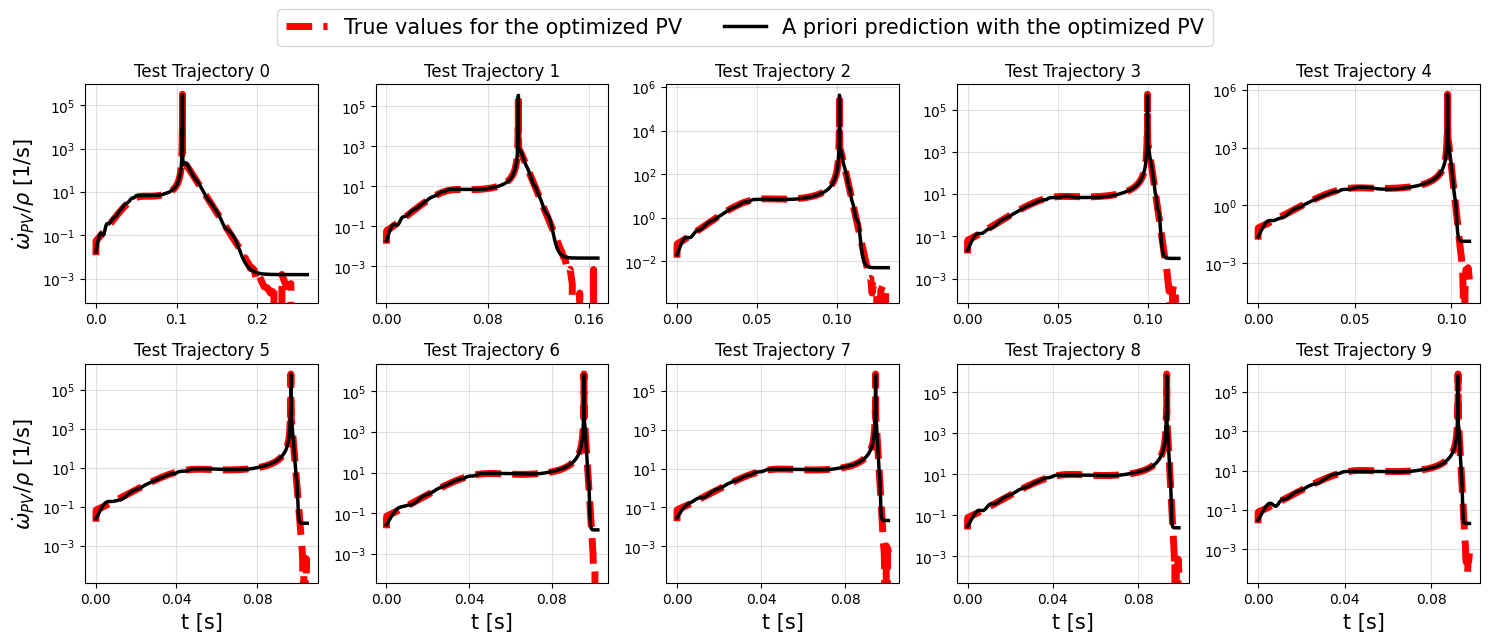

In [ ]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"
name = f"Apriori_ANN_{regression_modelname_optimized_complete}.png"
namePdf = f"Apriori_ANN_{regression_modelname_optimized_complete}.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    ax.plot(test_trajectory_time, PV_optimized_source_test, label="True values for the optimized PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time, prediction_test_trajectories_optimized_sparse[i], label="A priori prediction with the optimized PV", color = "k", linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

C:\Windows\Temp\ipykernel_27532\1900427318.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


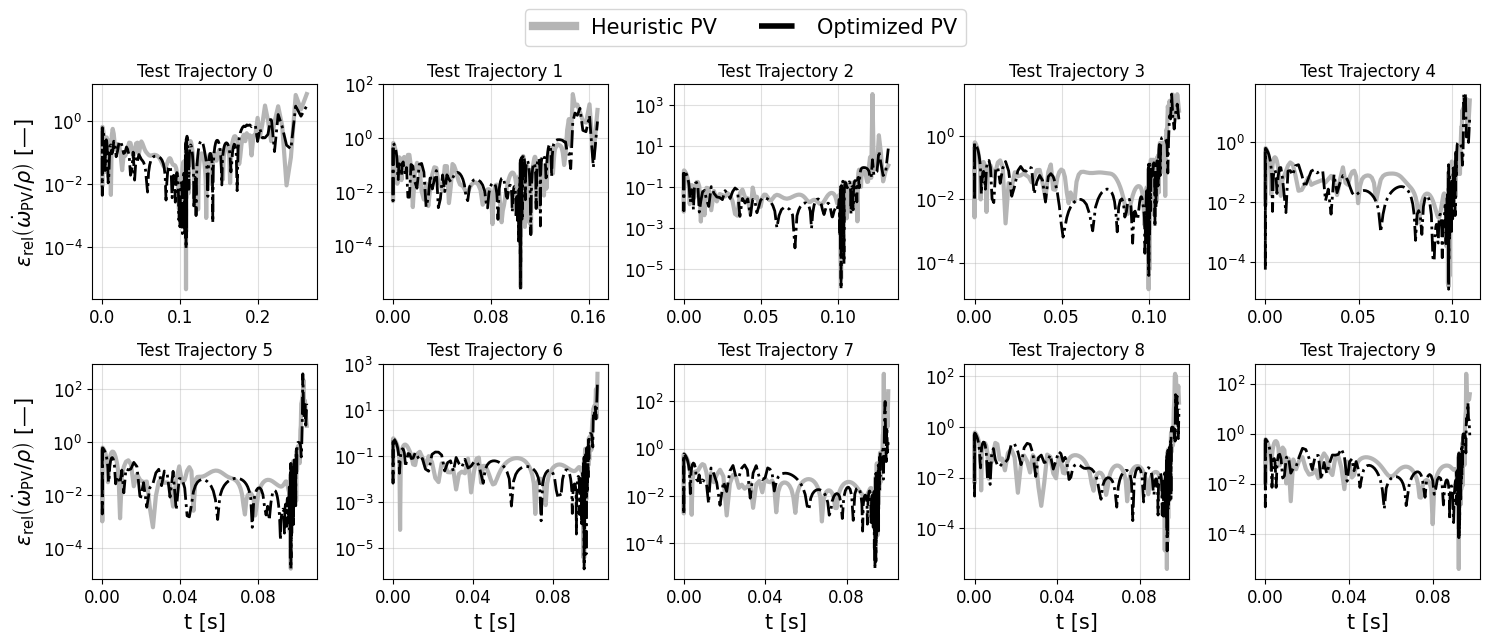

In [27]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"
name = f"Sparse vs complete optimized {id_model_sparse} vs {id_model_complete} - A priori - relative Error comparison - ANN"
namePdf = f"Sparse vs complete optimized {id_model_sparse} vs {id_model_complete} - A priori - relative Error comparison - ANN.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

greys = cm.get_cmap('Greys')

for i in range(num_test_trajectories):
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_sparse_source_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        
        PV_optimized_complete_source_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    relativeErrorXu = np.abs(PV_optimized_complete_source_test.flatten() - prediction_test_trajectories_optimized_complete[i].flatten())/np.abs(PV_optimized_complete_source_test.flatten())
    relErrorOptimized = np.abs(prediction_test_trajectories_optimized_sparse[i].flatten() - PV_optimized_sparse_source_test.flatten())/np.abs(PV_optimized_sparse_source_test.flatten())
    ax.plot(test_trajectory_time, relativeErrorXu, label = "Heuristic PV", color = greys(0.4), linewidth = 3, linestyle = "-")
    ax.plot(test_trajectory_time, relErrorOptimized, label = "Optimized PV", color = "k", linewidth = 2, linestyle = "-.")
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yscale("log")
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)

    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r"$\epsilon_{\mathrm{rel}}\left( \dot{\omega}_{\mathrm{PV}} / \rho \right)$" + " [\u2014]", fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 2,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

## Evolve optimized PV over time

In [14]:
class ODEOptimized_sparse(torch.nn.Module):

    def __init__(self, min_max_PV):
        super().__init__()
        self.min_PV = min_max_PV[0]
        self.max_PV = min_max_PV[1]

    def forward(self, t, y):
        y_scaled = y.clone() #avoid in place changes
        if scaledManifold_opt:
            y_scaled[1] = (y_scaled[1] - self.min_PV)/(self.max_PV - self.min_PV)
                
        
        #print(y)
        
        f_PV = (y_scaled-mins_input_optimized_sparse) / (maxs_input_optimized_sparse - mins_input_optimized_sparse) - 0.5
        PV_source_predicted = model_regression_optimized_sparse(f_PV)
        PV_source_predicted = (PV_source_predicted+1) /2 * (maxs_output_optimized_sparse - mins_output_optimized_sparse) + mins_output_optimized_sparse
        
        if(log_transform_opt == "continuous-symlog"):
            PV_optimized_source_test_predicted = inverse_symlog(PV_source_predicted, epsilon)
        elif(log_transform_opt == "log"):
            PV_optimized_source_test_predicted = 10**PV_source_predicted

        zero = torch.tensor([[0.0]], dtype=PV_optimized_source_test_predicted.dtype, device=PV_optimized_source_test_predicted.device)
        f_PV_source_predicted = torch.cat((zero, PV_optimized_source_test_predicted), dim=1) #add a zero for the mixture fraction
        

        return f_PV_source_predicted.squeeze()

In [15]:
idx_start_simulation = 0
list_simulations_optimized_sparse = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Predicted")

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_sparse_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        f_PV_optimized_sparse_test = np.hstack((np.full(PV_optimized_sparse_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_sparse_test.reshape(-1,1)))
        f_PV_optimized_sparse_test = torch.from_numpy(f_PV_optimized_sparse_test).clone().detach()

        
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_optimized_sparse_test[idx_start_simulation,:]

    t_coordinates = test_trajectory_time[idx_start_simulation:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    
    ODEOptimized_sparse_instance = ODEOptimized_sparse([PV_optimized_sparse_test.min(), PV_optimized_sparse_test.max()])
    numerical_solution_optimized_sparse = odeint(ODEOptimized_sparse_instance, initial_condition, t_coordinates)#, method="rk4")
    list_simulations_optimized_sparse.append(numerical_solution_optimized_sparse) 

    MSE_optimized_test_simulation = mean_squared_error(PV_optimized_sparse_test[idx_start_simulation:], numerical_solution_optimized_sparse.squeeze()[:,1].detach().numpy())

    print(f"MSE for test trajectory {i}: {MSE_optimized_test_simulation}")

Predicted
MSE for test trajectory 0: 3.4365416021403403
MSE for test trajectory 1: 16.473999258111956
MSE for test trajectory 2: 21.475576830698408
MSE for test trajectory 3: 26.2064177964158
MSE for test trajectory 4: 29.485172465370248
MSE for test trajectory 5: 29.82668479269651
MSE for test trajectory 6: 29.156129417509852
MSE for test trajectory 7: 32.29169563069379
MSE for test trajectory 8: 31.303647270789597
MSE for test trajectory 9: 33.386323330113484


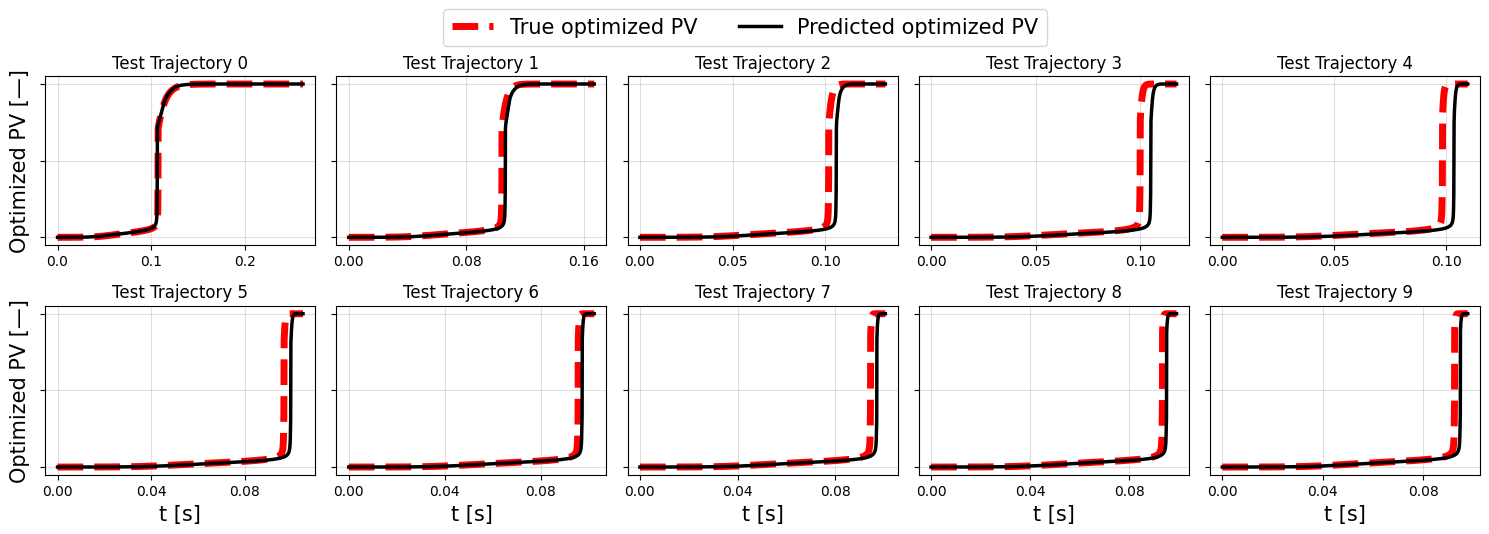

In [36]:
save = True
zoom = False
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"


num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(num_test_trajectories):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]

    PV_min = PV_optimized_test[idx_start_simulation:].min()
    PV_max = PV_optimized_test[idx_start_simulation:].max()

    #-(list_simulations_optimized[i][:,1]-PV_min)/(PV_max - PV_min)+1

    if(zoom):
        ##############################################
        # Get the first and last index of the ignition
        ##############################################

        H2O_array = test_trajectory["H2O"].to_numpy()
        
        max_val = H2O_array.max()
        min_perc = 0.0028
        max_perc = 0.999
        lower_threshold = min_perc * max_val
        upper_threshold = max_perc * max_val

        idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
        idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

        ax.plot(test_trajectory_time[idx_1:idx_99], -(PV_optimized_test[idx_1:idx_99]-PV_min)/(PV_max - PV_min)+1, label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_1:idx_99], -(list_simulations_optimized_sparse[i][idx_1:idx_99,1]-PV_min)/(PV_max - PV_min)+1, label="Predicted optimized PV", color = "k", linewidth = 2.5) #idx_end-idx_start_simulation
    else:
        ax.plot(test_trajectory_time[idx_start_simulation:], (PV_optimized_test[idx_start_simulation:]-PV_min)/(PV_max - PV_min), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_optimized_sparse[i][:,1].detach().numpy()-PV_min)/(PV_max - PV_min), label="Predicted optimized PV", color = "k", linewidth = 2.5) #idx_end-idx_start_simulation
    
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    #ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

    ax.grid(True, linestyle='-', alpha=0.4)

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

name = f"Sparse vs complete optimized {id_model_sparse} - ANN {regression_modelname_optimized_complete}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.png"
namePdf = f"Sparse vs complete optimized {id_model_sparse} - ANN {regression_modelname_optimized_complete}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.pdf"

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

<h3> Run the a posteriori simulation longer

In [16]:
list_simulations_optimized_sparse_ext = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Predicted")

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        f_PV_optimized_sparse_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        f_PV_optimized_sparse_test = torch.from_numpy(f_PV_optimized_sparse_test).clone().detach()

        
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_optimized_sparse_test[0,:]

    t_coordinates = test_trajectory_time[0:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    deltaTime = t_coordinates[-1] - t_coordinates[-2]

    last_value = t_coordinates[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        t_coordinates = torch.cat((t_coordinates, extension))
    
    ODEOptimized_instance = ODEOptimized_sparse([PV_optimized_test.min(), PV_optimized_test.max()])
    numerical_solution_optimized_sparse = odeint(ODEOptimized_instance, initial_condition, t_coordinates)#, method="rk4")
    list_simulations_optimized_sparse_ext.append(numerical_solution_optimized_sparse) 

Predicted


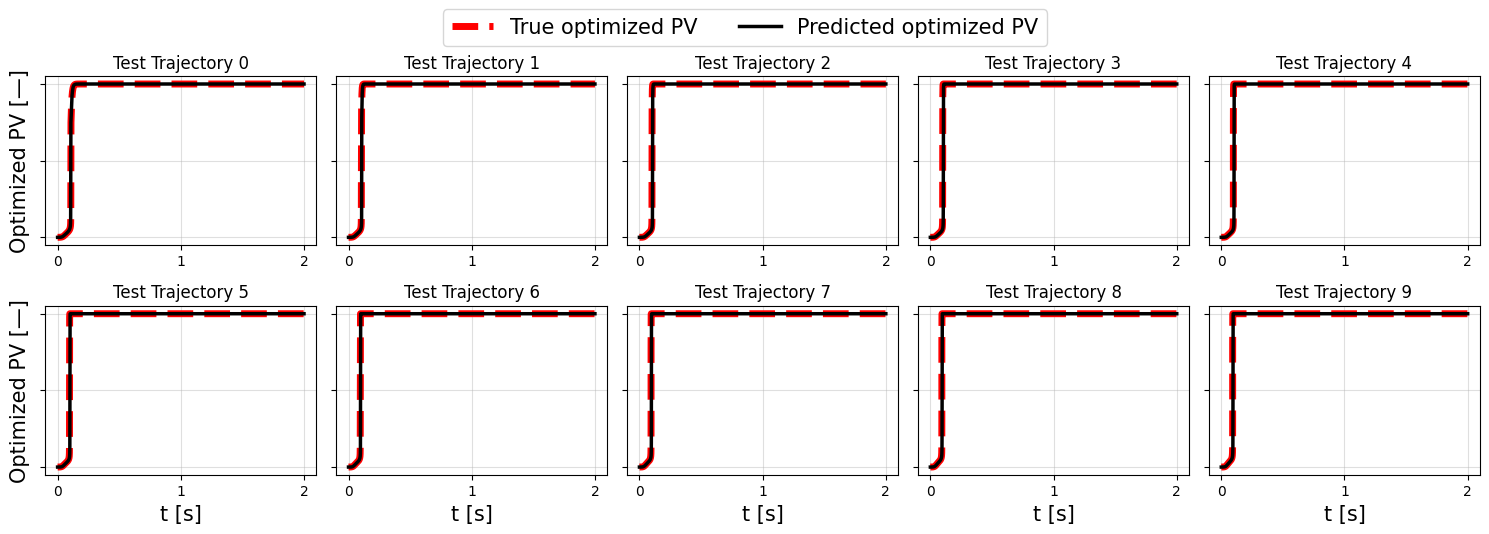

In [38]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"
name = f"Sparse vs complete optimized - ANN {regression_modelname_optimized_complete}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.png"
namePdf = f"Sparse vs complete optimized - ANN {regression_modelname_optimized_complete}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_optimized_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_optimized_test
        PV_optimized_test_ext = np.vstack((PV_optimized_test, extension)) #concatenate the extension with the original value
    
    min_PV = PV_optimized_test.min()
    max_PV = PV_optimized_test.max()
    
    ax = axes[i]
    ax.plot(test_trajectory_time_ext, (PV_optimized_test_ext-min_PV)/(max_PV-min_PV), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
    ax.plot(test_trajectory_time_ext, (list_simulations_optimized_sparse_ext[i].squeeze()[:,1].detach().numpy()-min_PV)/(max_PV-min_PV), label="Predicted optimized PV", color = "k", linewidth = 2.5) #idx_end-idx_start_simulation
    ax.set_title(f"Test Trajectory {i}")
    ax.set_xticks([0, 1 , 2])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

    ax.grid(True, linestyle='-', alpha=0.4)

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

In [17]:
def ignition_time_difference(time_array, pv_true, pv_pred, threshold=0.99):
    """
    Compute the time difference between true and predicted PV ignition times.
    
    Parameters
    ----------
    time_array : np.ndarray
        1D array of time values.
    pv_true : np.ndarray
        1D array of true PV values (same length as time_array).
    pv_pred : np.ndarray
        1D array of predicted PV values (same length as time_array).
    threshold : float, optional
        The PV threshold for ignition (default: 0.99).
    
    Returns
    -------
    float or None
        The time difference (predicted - true) when both trajectories reach
        the threshold. Returns None if either trajectory never reaches it.
    """
    # Find first index where true PV >= threshold
    true_idx = np.argmax(pv_true >= threshold) if np.any(pv_true >= threshold) else None
    # Find first index where predicted PV >= threshold
    pred_idx = np.argmax(pv_pred >= threshold) if np.any(pv_pred >= threshold) else None

    if true_idx is None or pred_idx is None:
        return None  # one of them never reaches threshold

    true_time = time_array[true_idx]
    pred_time = time_array[pred_idx]

    return np.round(pred_time - true_time, 3), np.round(np.abs(pred_time - true_time)/pred_time*100, 3)

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_optimized_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
        PV_optimized_test_ext = np.vstack((PV_optimized_test, extension)) #concatenate the extension with the original value

    min_PV = PV_optimized_test_ext.min()
    max_PV = PV_optimized_test_ext.max()

    true_PV_norm = (PV_optimized_test_ext - min_PV) / (max_PV - min_PV)
    pred_PV_norm = (list_simulations_optimized_sparse_ext[i].squeeze()[:,1].detach().numpy() - min_PV) / (max_PV - min_PV)

    # Compute ignition time difference
    dt, perc = ignition_time_difference(np.array(test_trajectory_time_ext), true_PV_norm, pred_PV_norm)
    print(f"Ignition time difference of traj {i}:", dt, f"s - {perc}%")

Ignition time difference of traj 0: -0.002 s - 1.486%
Ignition time difference of traj 1: 0.003 s - 2.202%
Ignition time difference of traj 2: 0.004 s - 4.027%
Ignition time difference of traj 3: 0.005 s - 4.89%
Ignition time difference of traj 4: 0.005 s - 5.163%
Ignition time difference of traj 5: 0.003 s - 2.944%
Ignition time difference of traj 6: 0.002 s - 1.697%
Ignition time difference of traj 7: 0.003 s - 2.727%
Ignition time difference of traj 8: 0.002 s - 1.777%
Ignition time difference of traj 9: 0.002 s - 2.482%


## A posteriori: PV trajectory

<h3> Reconstruction to the full state space

In [18]:
#Load the model

with open(f'{path_regression_model}{regression_full_modelname_optimized_sparse}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_full_optimized_sparse = loaded_dict["mins_input"]
maxs_input_full_optimized_sparse = loaded_dict["maxs_input"]
mins_output_full_optimized_sparse = loaded_dict["mins_output"]
maxs_output_full_optimized_sparse = loaded_dict["maxs_output"]

scaledManifold_full_opt_sparse = loaded_dict["scaleManifold"]

neuron_layers = loaded_dict["neuron_layers"]
max_epo = loaded_dict["max_epo"]

model_regression_full_optimized_sparse = ANN_regression(**model_params)
model_regression_full_optimized_sparse.load_state_dict(torch.load(f"{path_regression_model}{regression_full_modelname_optimized_sparse}_model.pth", weights_only=False))

print(f"Final MSE: {loaded_dict['final validation error']}")

Output_species = loaded_dict["Output_species"]

for i in range(10):
    f_PV_array = list_simulations_optimized_sparse[i][:].clone()


    if(scaledManifold_full_opt_sparse):
        with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
        f_PV_array[:, 1] = (f_PV_array[:, 1] - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    f_PV_array_scaled = (f_PV_array - mins_input_full_optimized_sparse)/(maxs_input_full_optimized_sparse - mins_input_full_optimized_sparse) - 0.5
    prediction_optimized = model_regression_full_optimized_sparse(f_PV_array_scaled)

Final MSE: 8.507737912153267e-06


<h3> Comparison of the sparse and complete optimized PV

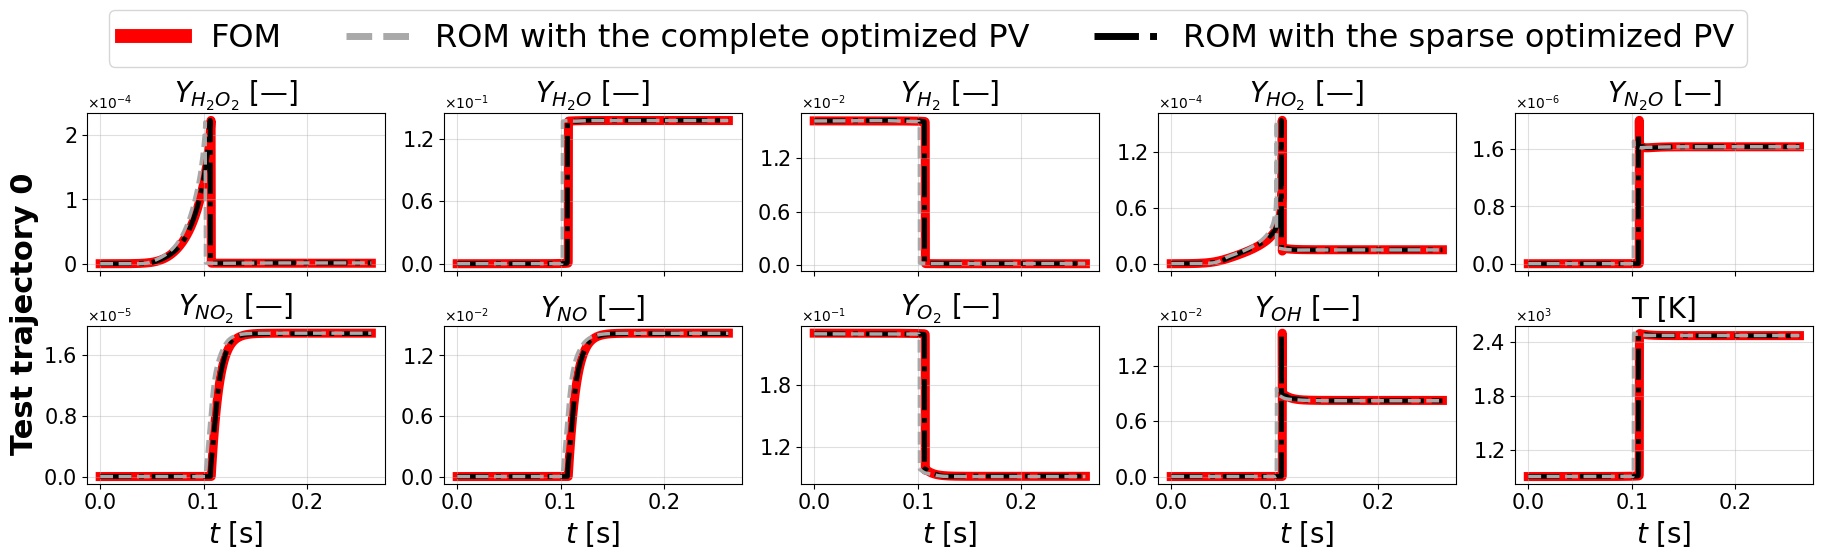

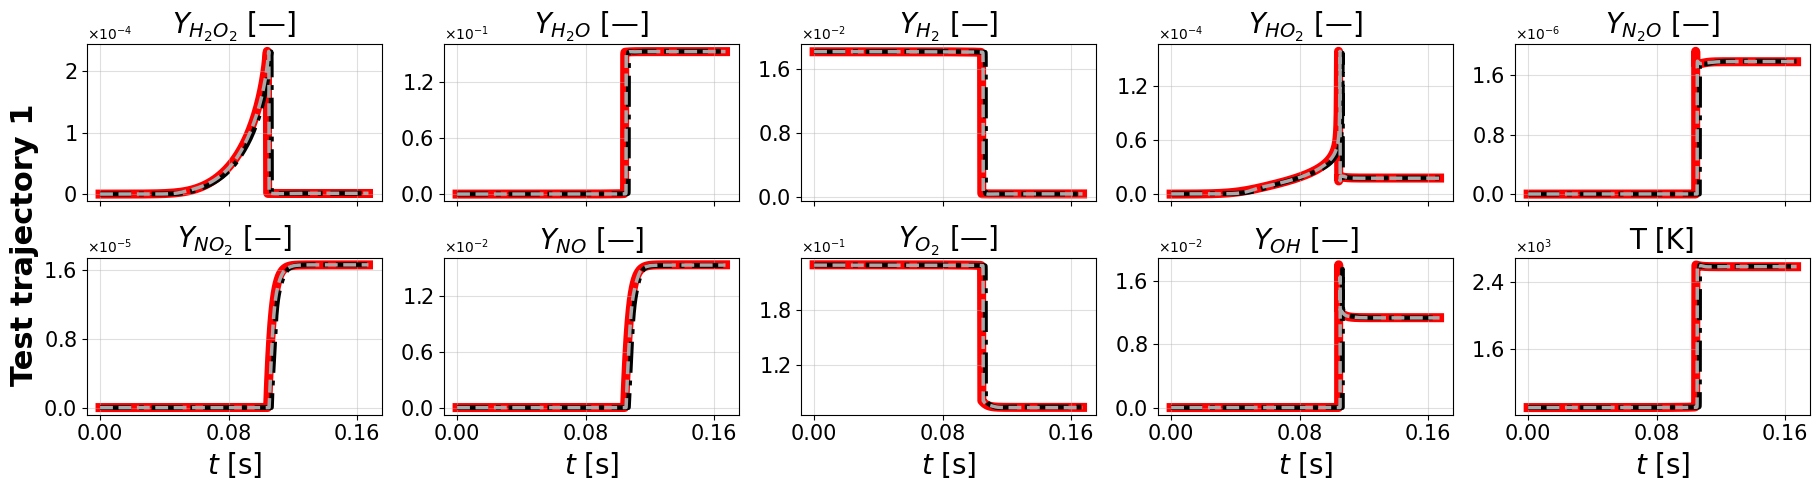

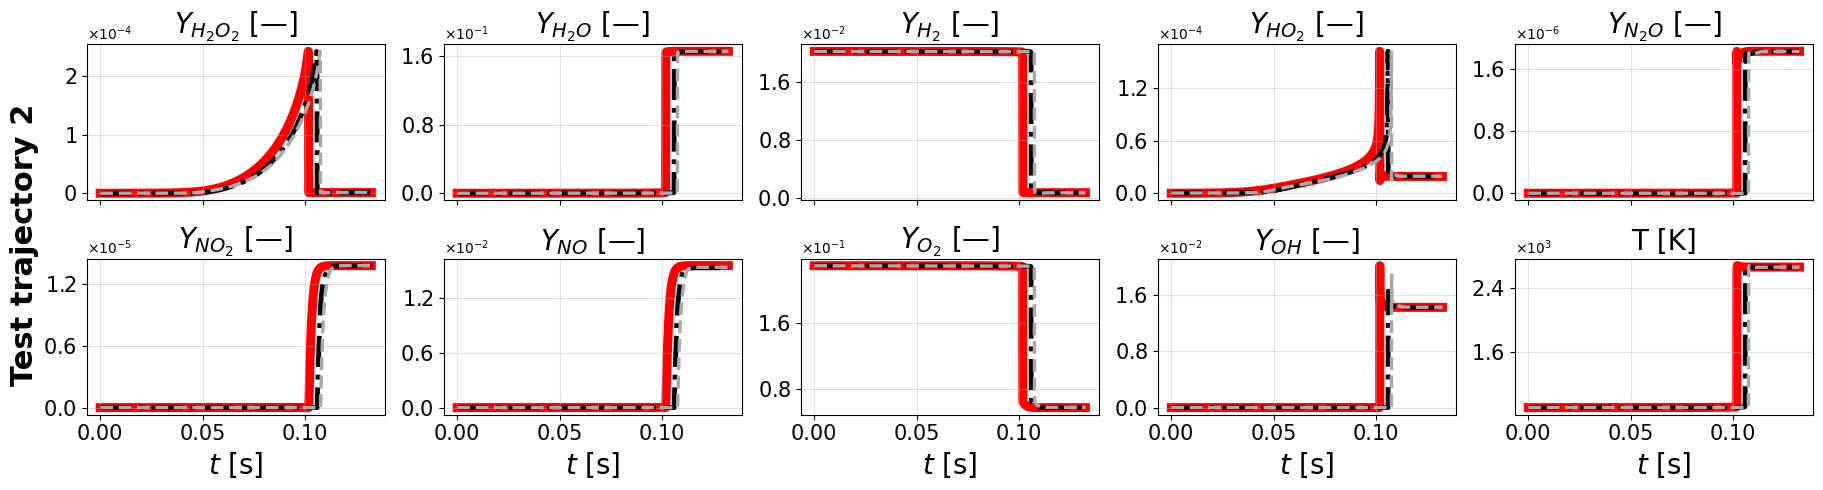

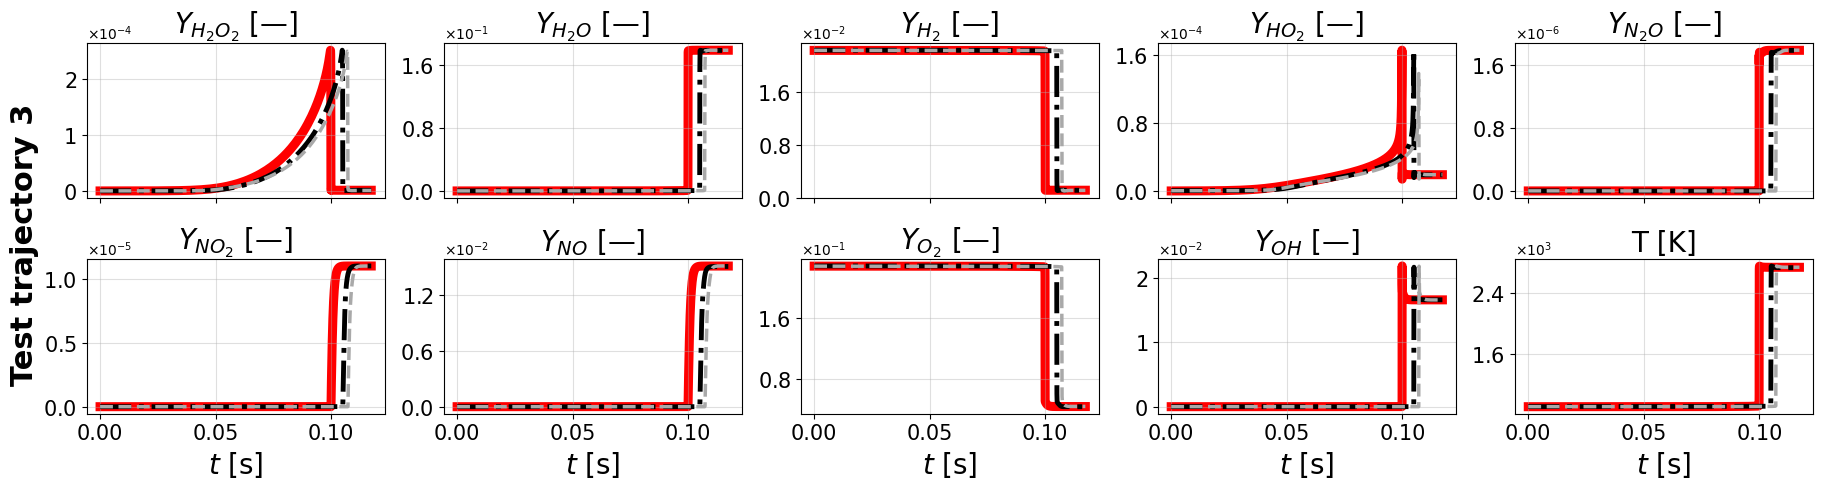

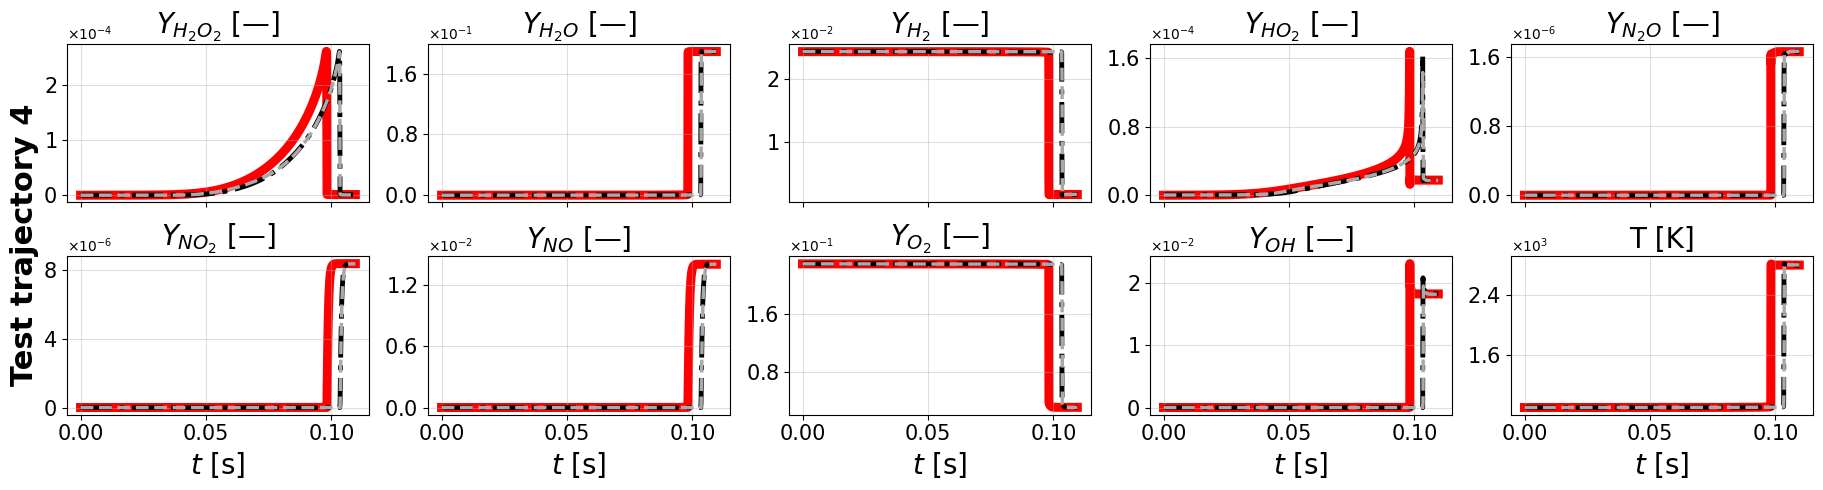

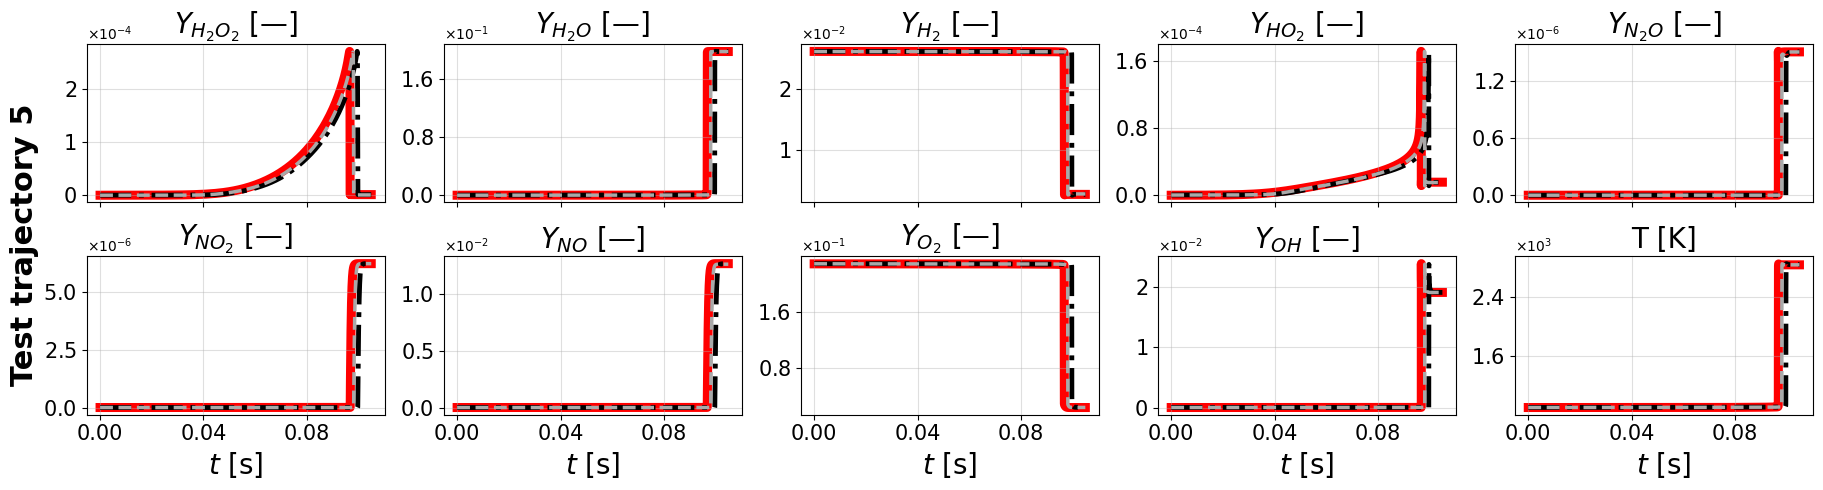

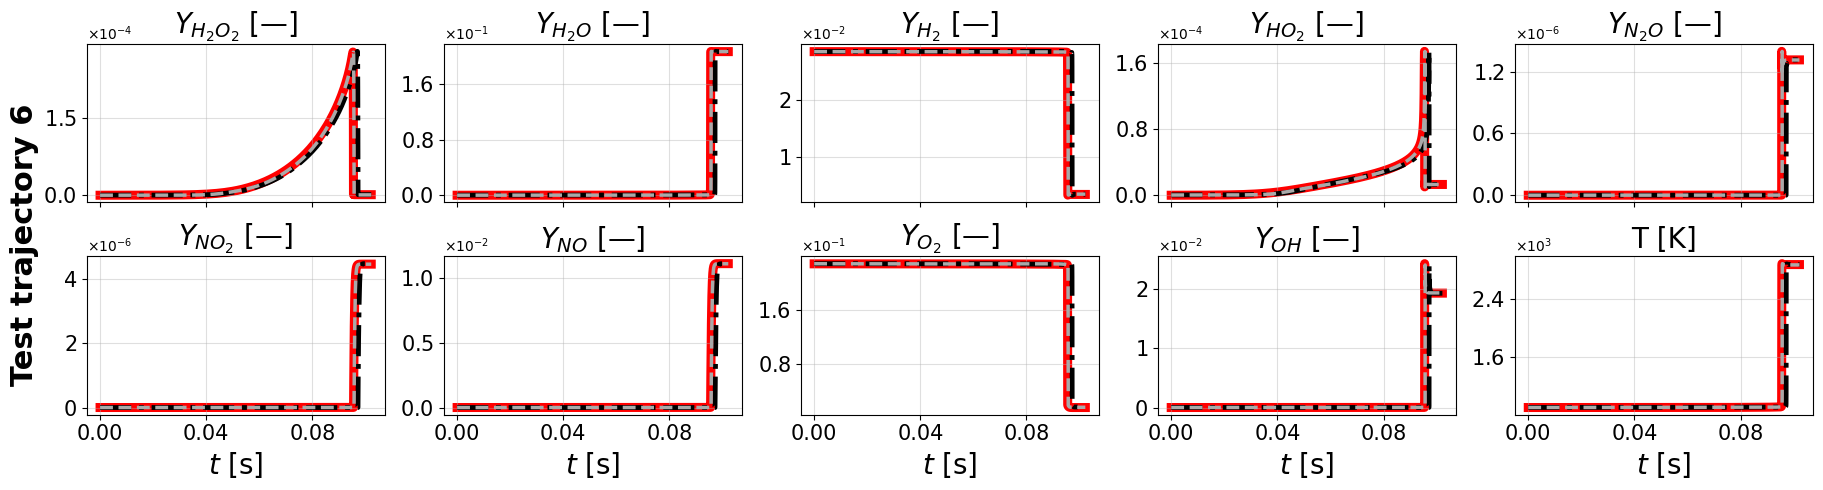

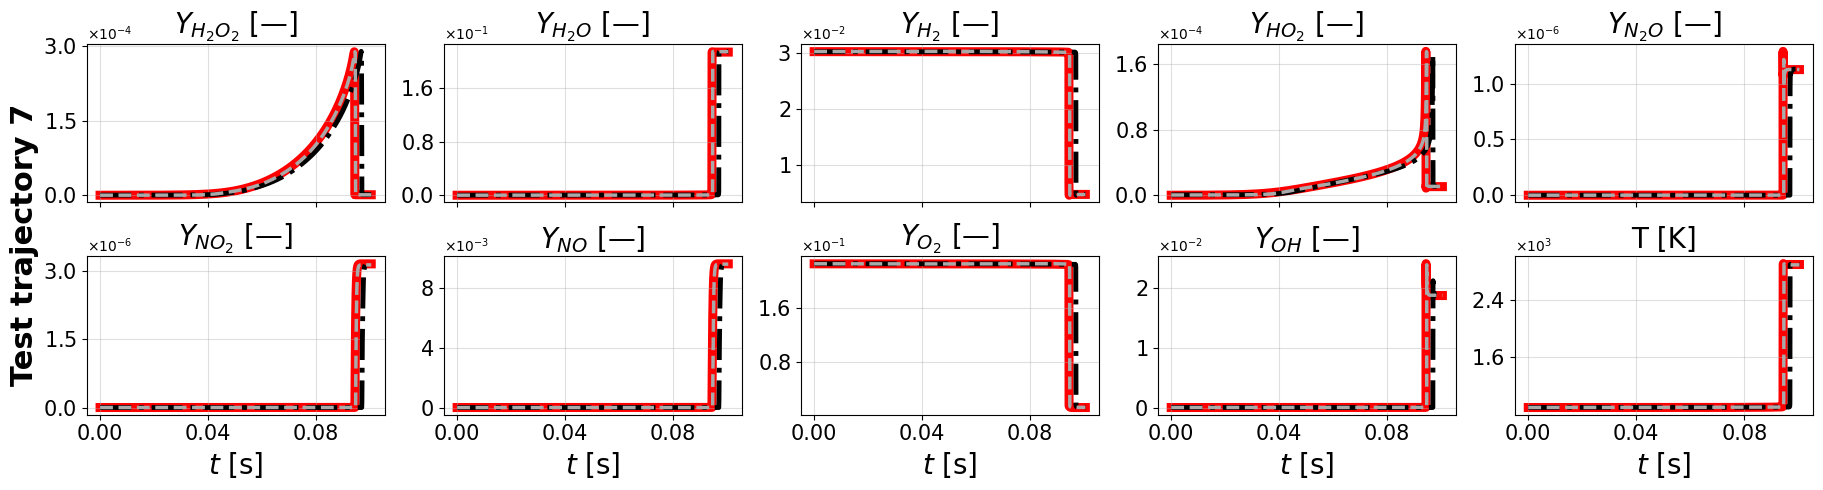

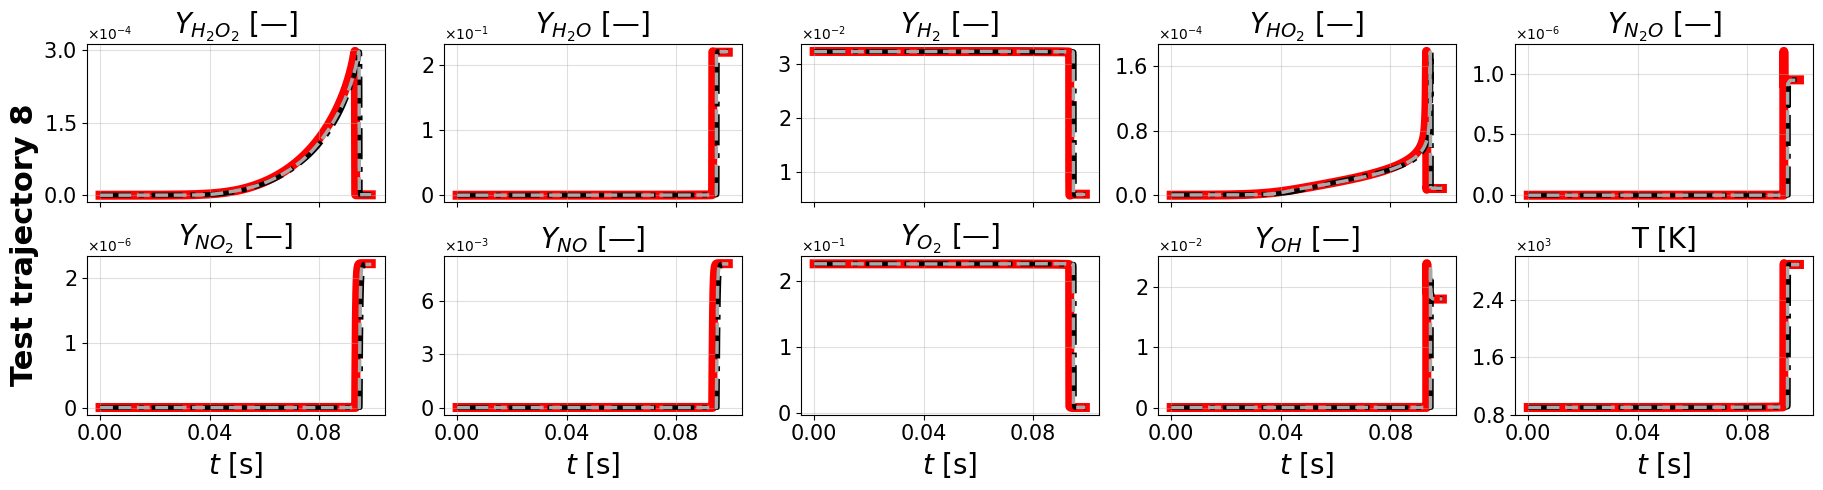

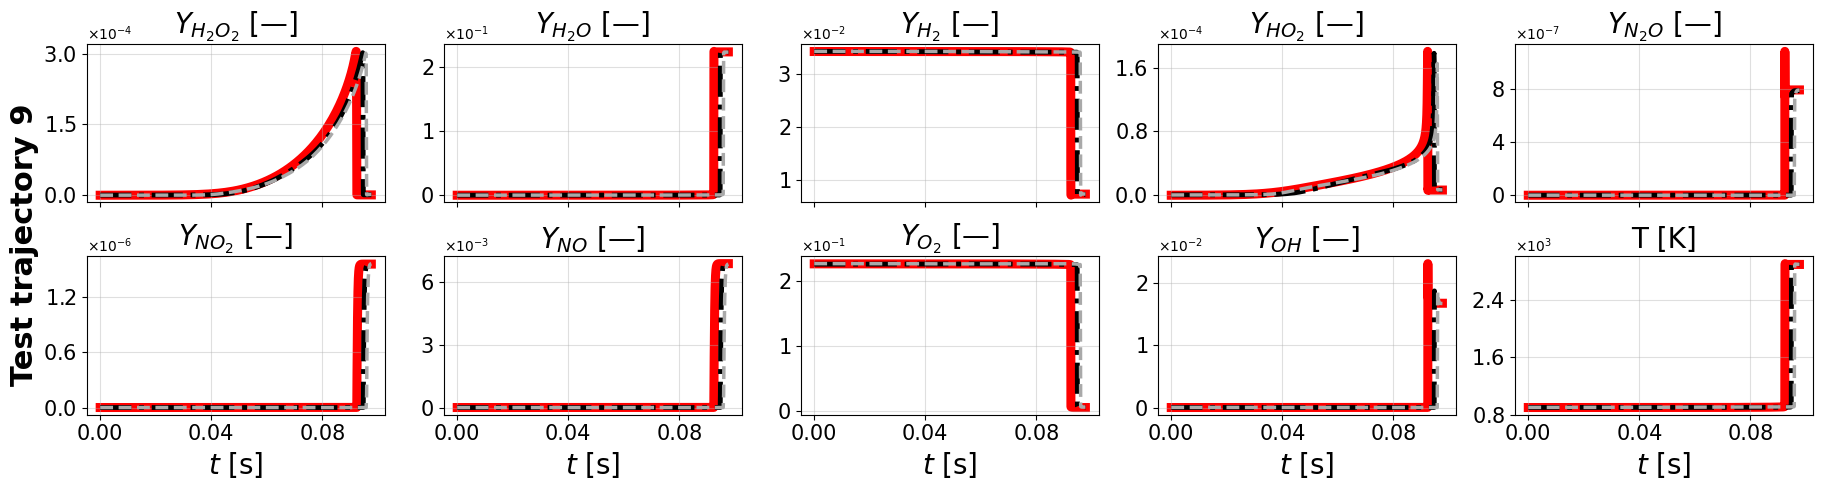

In [53]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"
name = f"Sparse vs complete opt PV - A posteriori"

Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

num_test_trajectories = 10

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])

    f_PV_opt_complete = list_simulations_optimized_complete[idxSimulation][:].detach().clone()

    if(scaledManifold_full_opt_complete):
      with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names) 
      state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
      PV_optimized_complete_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
      f_PV_opt_complete[:, 1] = (f_PV_opt_complete[:, 1] - PV_optimized_complete_test.min())/(PV_optimized_complete_test.max() - PV_optimized_complete_test.min())

    f_PV_opt_sparse = list_simulations_optimized_sparse[idxSimulation][:].clone()

    if(scaledManifold_full_opt_sparse):
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_sparse_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
        f_PV_opt_sparse[:, 1] = (f_PV_opt_sparse[:, 1] - PV_optimized_sparse_test.min())/(PV_optimized_sparse_test.max() - PV_optimized_sparse_test.min())
    
    prediction_optimized_complete = (model_regression_full_optimized_complete((f_PV_opt_complete-mins_input_optimized_complete)/(maxs_input_full_optimized_complete-mins_input_full_optimized_complete) - 0.5) + 1) /2 * (maxs_output_full_optimized_complete - mins_output_full_optimized_complete) + mins_output_full_optimized_complete
    prediction_optimized_complete = prediction_optimized_complete.detach().numpy()

    prediction_optimized_sparse = (model_regression_full_optimized_sparse((f_PV_opt_sparse-mins_input_full_optimized_sparse)/(maxs_input_full_optimized_sparse-mins_input_full_optimized_sparse) - 0.5) + 1) /2 * (maxs_output_full_optimized_sparse - mins_output_full_optimized_sparse) + mins_output_full_optimized_sparse
    prediction_optimized_sparse = prediction_optimized_sparse.detach().numpy()
    
    for idxQoI in range(len(Output_species)): 
      ax = axes[idxQoI]
      
      ax.plot(test_trajectory_time, test_trajectory[Output_species[idxQoI]], label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time, prediction_optimized_complete[:, idxQoI], label = "ROM with the complete optimized PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      ax.plot(test_trajectory_time, prediction_optimized_sparse[:, idxQoI], label = "ROM with the sparse optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
      
      if(Output_species[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)

      ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      formatter = ScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))
      ax.yaxis.set_major_formatter(formatter)
      ax.grid(True, linestyle='-', alpha=0.4)
          
    for j in range(len(Output_species), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with the complete optimized PV'),
        Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with the sparse optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout() #h_pad = 0

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")

    if(i==0):
        plt.show()

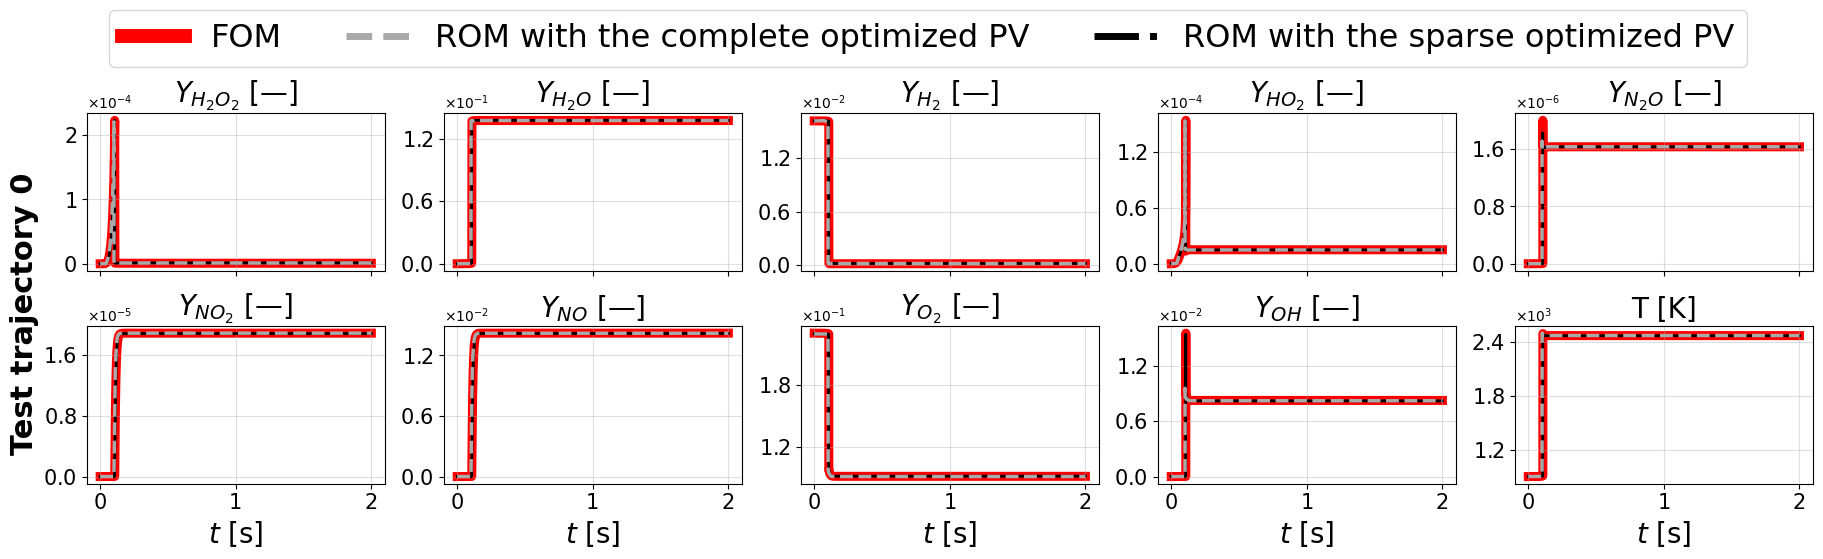

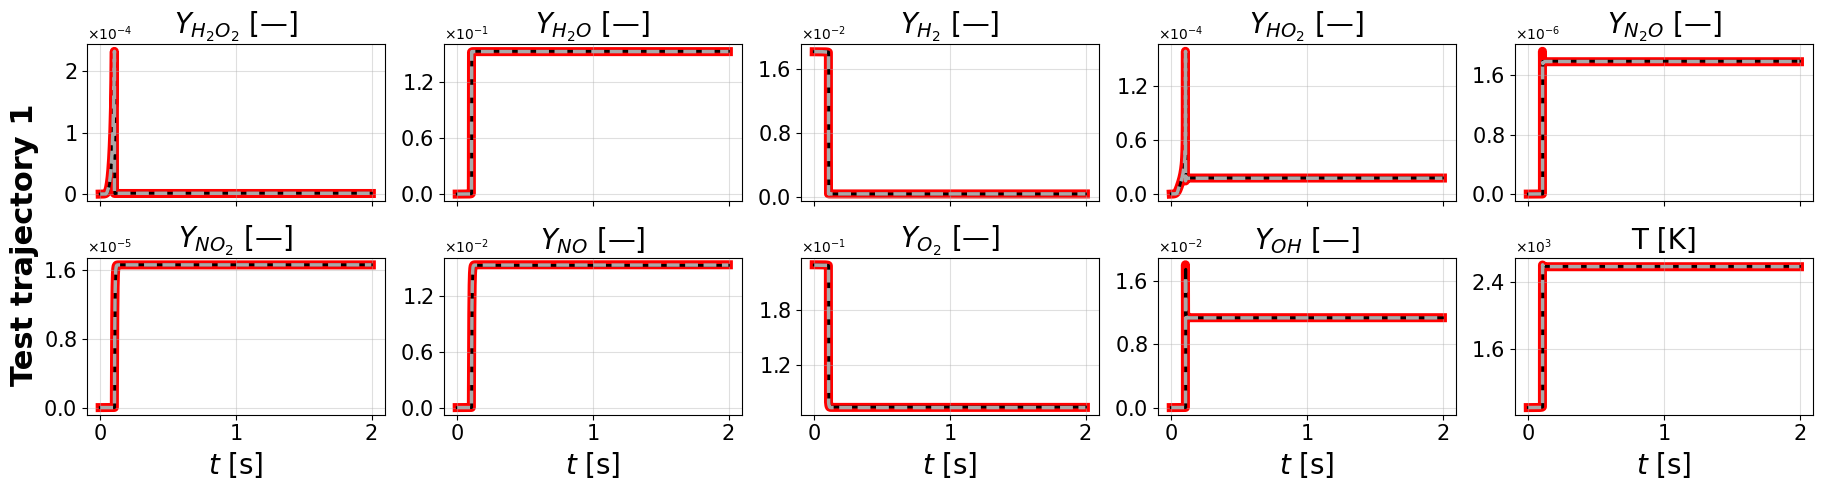

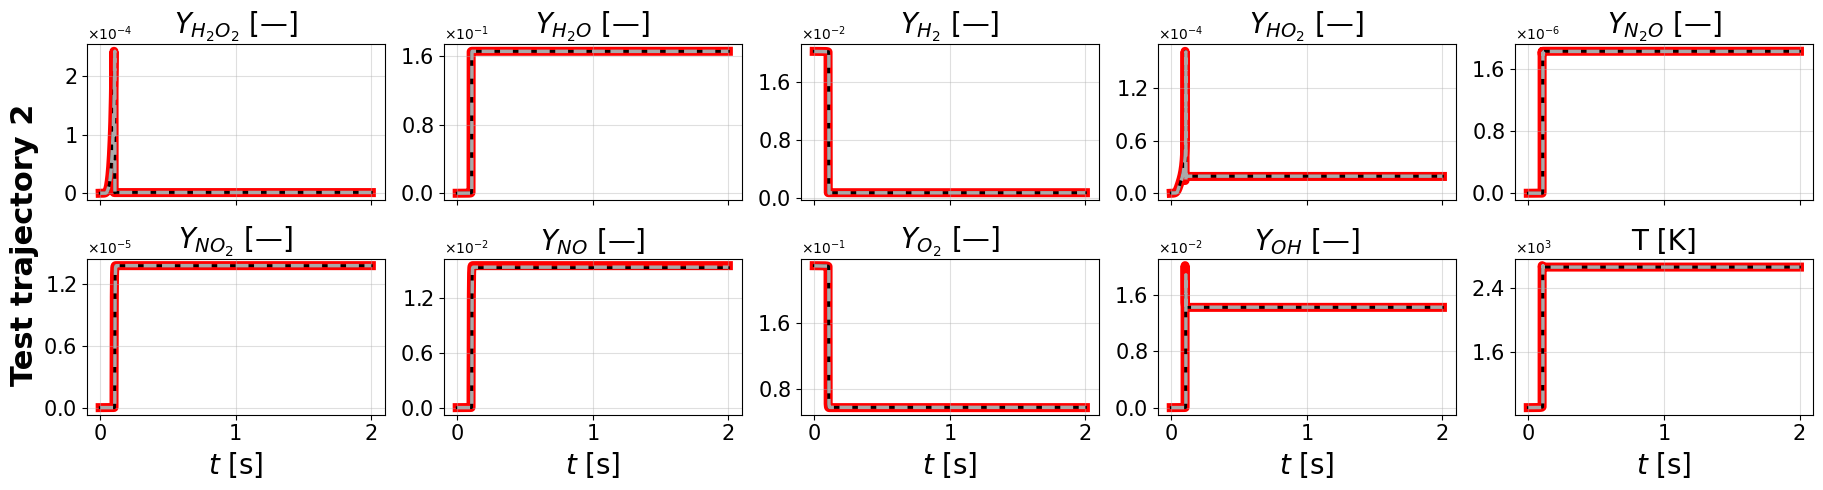

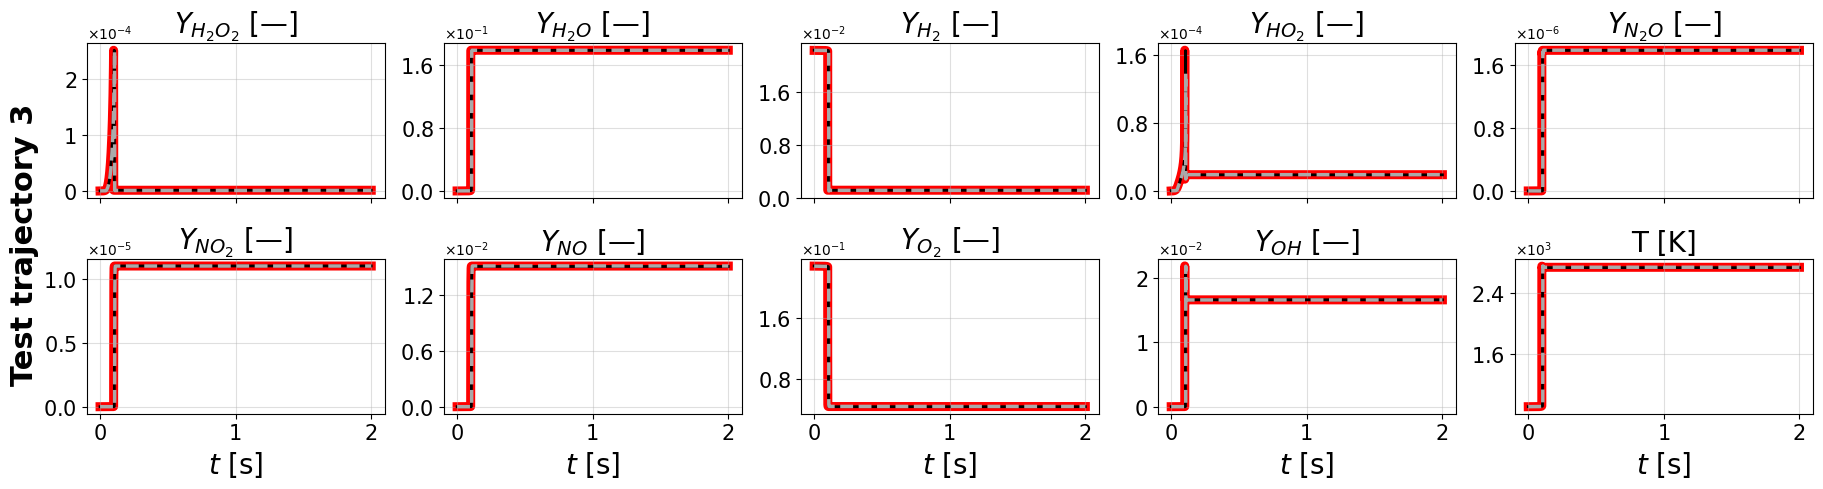

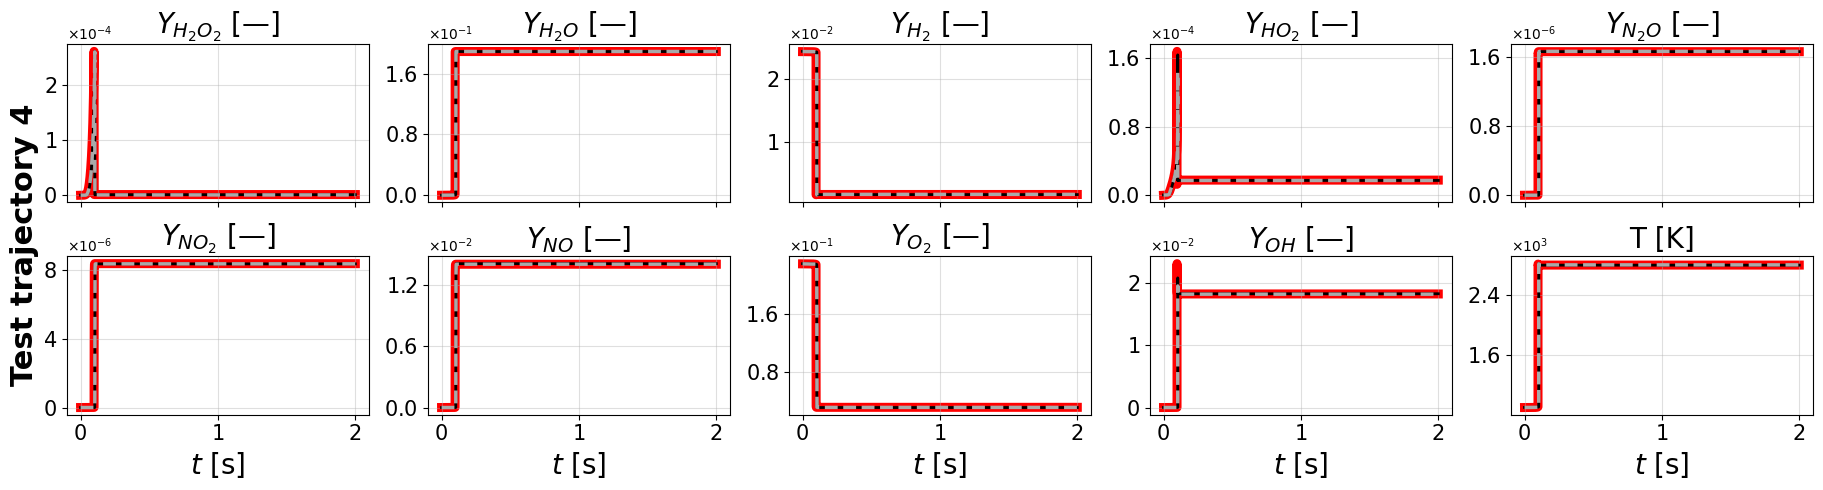

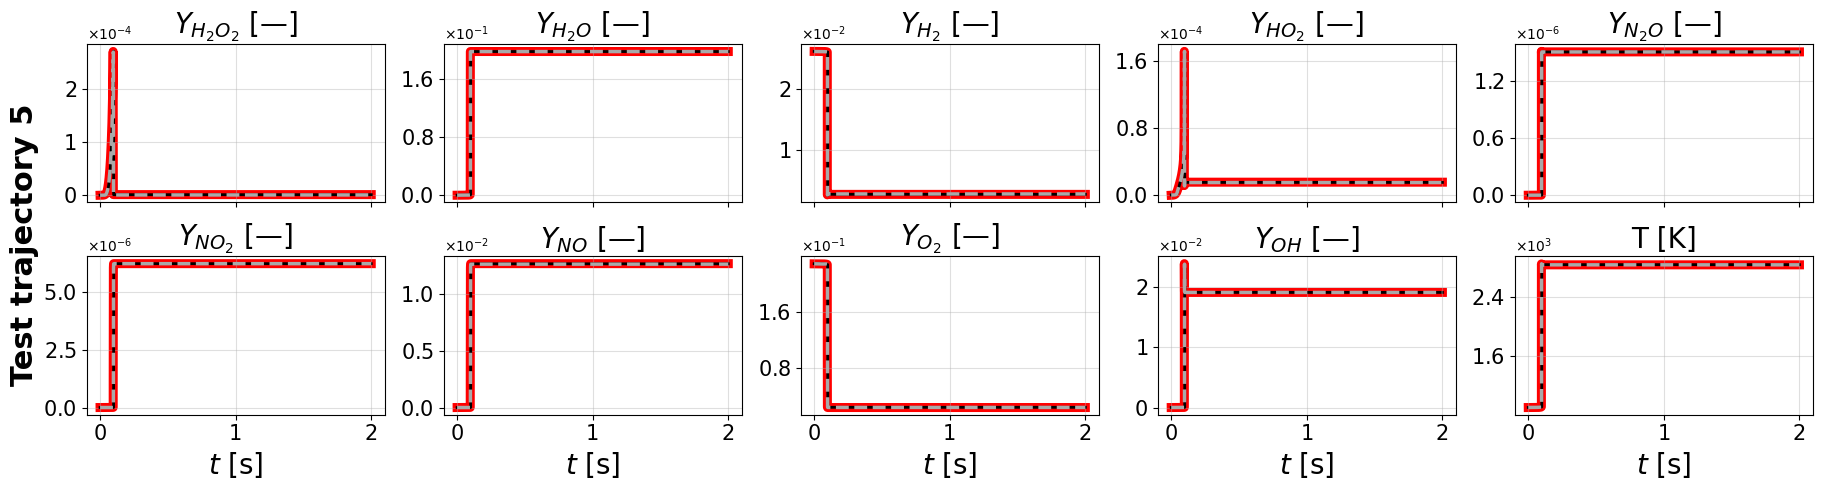

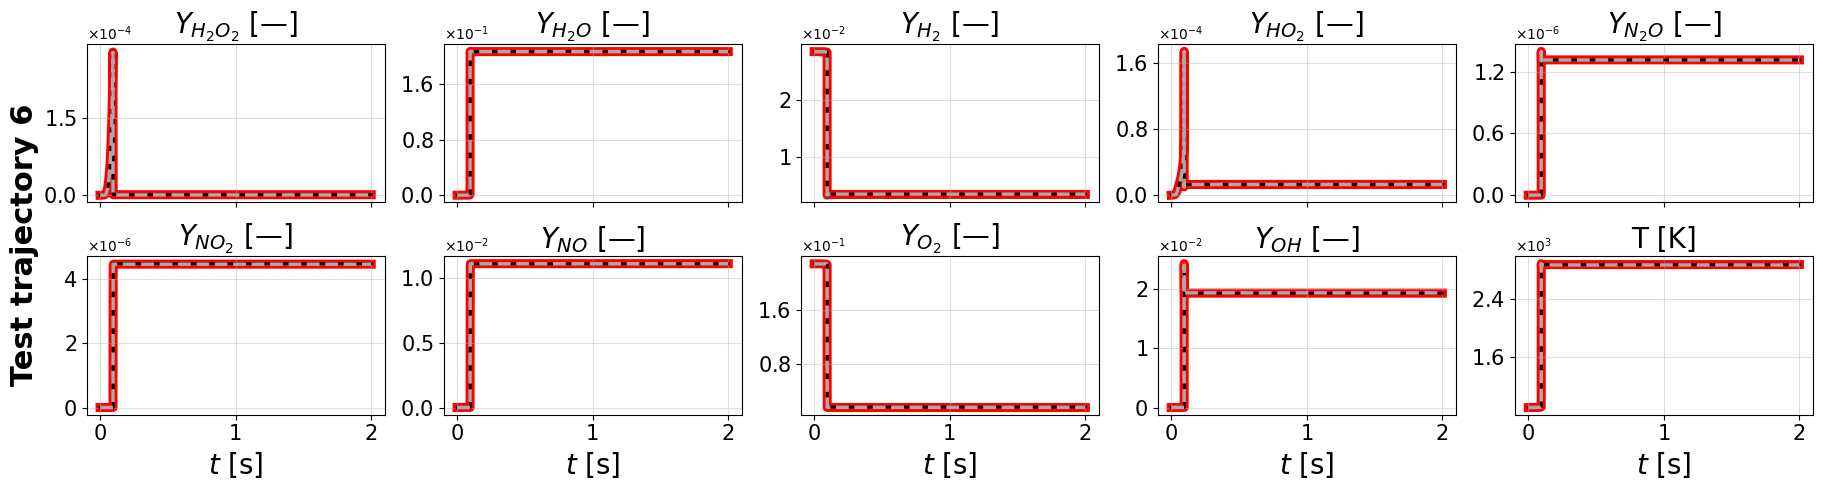

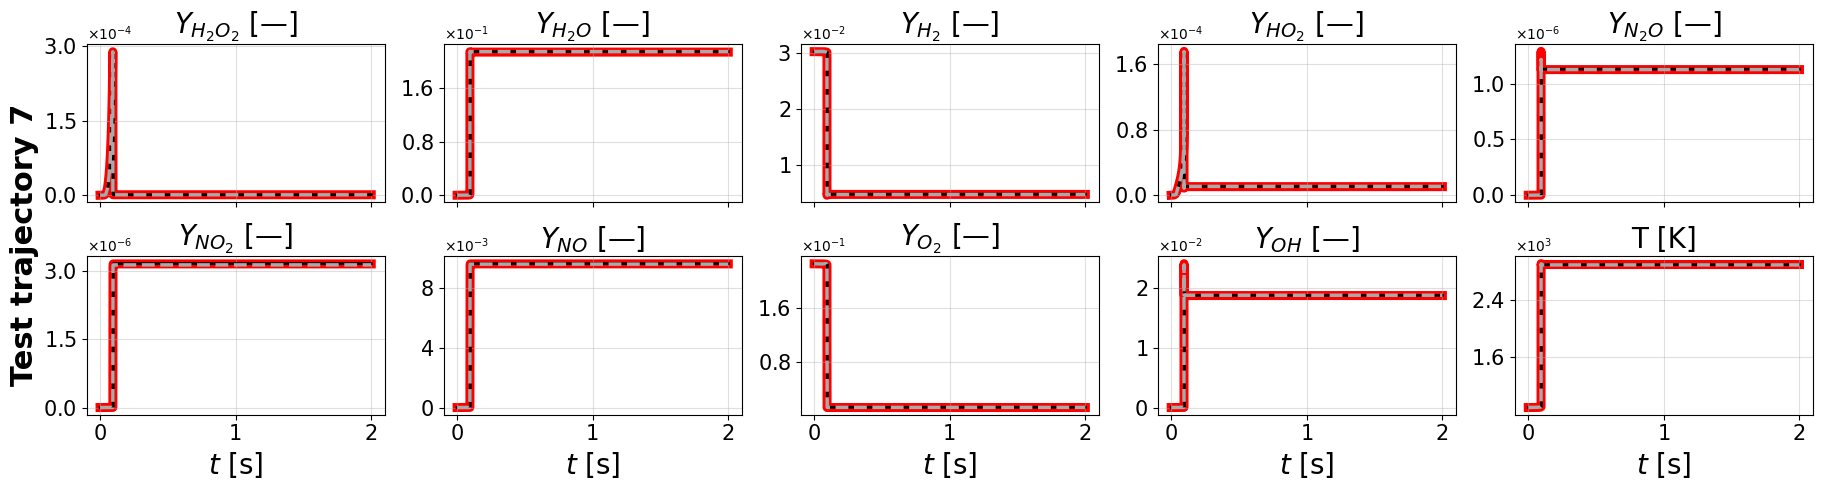

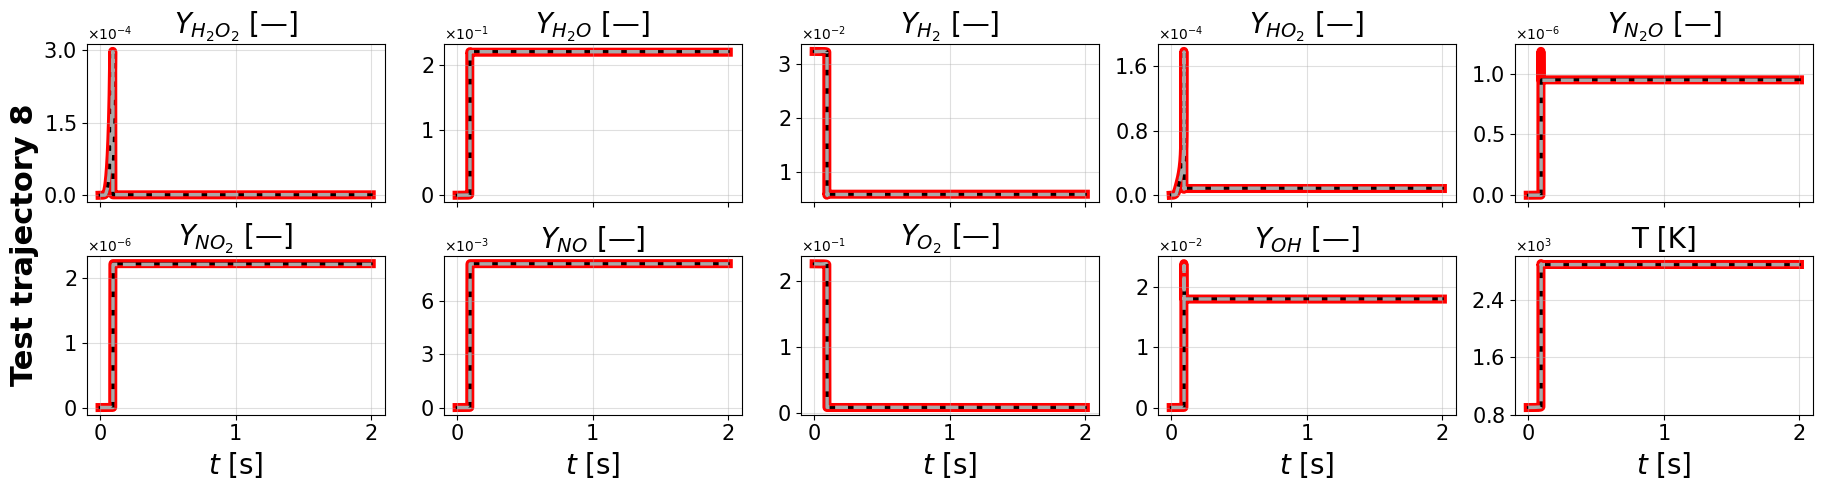

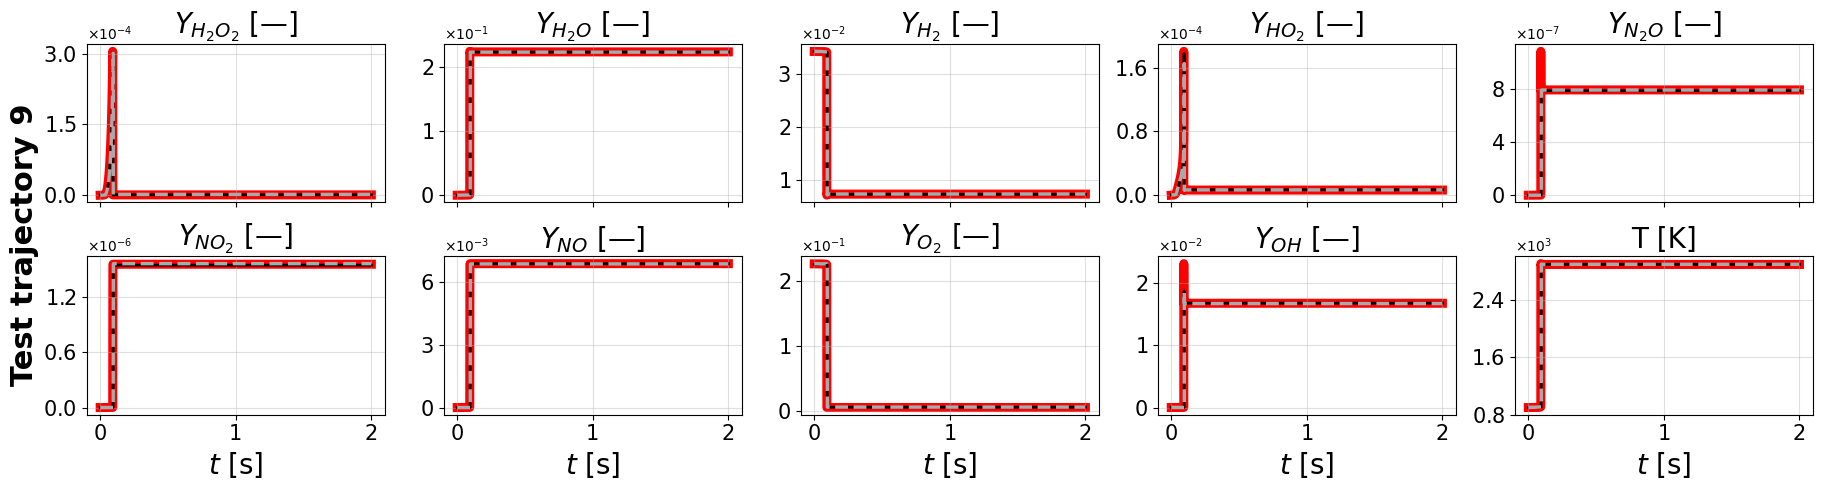

In [54]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"
name = f"Sparse vs complete opt PV - A posteriori - timeExt"

Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])
    

    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    
    for idxQoI in range(len(Output_species)): 
      ax = axes[idxQoI]

      #Add extension to the current tensor
      if new_times:
          extension = torch.tensor(new_times, dtype=torch.float32)
          test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

          last_value = test_trajectory[Output_species[idxQoI]].to_numpy()[-1]
          extension = np.tile(last_value, (len(new_times),))  #extension with last value of PV_optimized_test
          test_trajectory_QoI_ext = np.hstack((test_trajectory[Output_species[idxQoI]].to_numpy(), extension)) #concatenate the extension with the original value

      f_PV_opt_complete = list_simulations_optimized_complete_ext[idxSimulation][:].detach().clone()

      if(scaledManifold_full_opt_complete):
        with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
              test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names) 
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_complete_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
      
        f_PV_opt_complete[:, 1] = (f_PV_opt_complete[:, 1] - PV_optimized_complete_test.min())/(PV_optimized_complete_test.max() - PV_optimized_complete_test.min())

      f_PV_opt_sparse = list_simulations_optimized_sparse_ext[idxSimulation][:].clone()

      if(scaledManifold_full_opt_sparse):
          state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
          PV_optimized_sparse_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
      
          f_PV_opt_sparse[:, 1] = (f_PV_opt_sparse[:, 1] - PV_optimized_sparse_test.min())/(PV_optimized_sparse_test.max() - PV_optimized_sparse_test.min())
      
      prediction_optimized_complete = (model_regression_full_optimized_complete((f_PV_opt_complete-mins_input_optimized_complete)/(maxs_input_full_optimized_complete-mins_input_full_optimized_complete) - 0.5) + 1) /2 * (maxs_output_full_optimized_complete - mins_output_full_optimized_complete) + mins_output_full_optimized_complete
      prediction_optimized_complete = prediction_optimized_complete.detach().numpy()

      prediction_optimized_sparse = (model_regression_full_optimized_sparse((f_PV_opt_sparse-mins_input_full_optimized_sparse)/(maxs_input_full_optimized_sparse-mins_input_full_optimized_sparse) - 0.5) + 1) /2 * (maxs_output_full_optimized_sparse - mins_output_full_optimized_sparse) + mins_output_full_optimized_sparse
      prediction_optimized_sparse = prediction_optimized_sparse.detach().numpy()
      
      ax.plot(test_trajectory_time_ext, test_trajectory_QoI_ext, label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time_ext, prediction_optimized_complete[:, idxQoI], label = "ROM with the complete optimized PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      ax.plot(test_trajectory_time_ext, prediction_optimized_sparse[:, idxQoI], label = "ROM with the sparse optimized PV", c="k", linestyle="-", linewidth=2, zorder = 2)
      
      if(Output_species[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)
      ax.set_xticks([0, 1, 2])
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      formatter = ScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))
      ax.yaxis.set_major_formatter(formatter)
      ax.grid(True, linestyle='-', alpha=0.4)
          
    for j in range(len(Output_species), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with the complete optimized PV'),
        Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with the sparse optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout()

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")

    if(i==0):
        plt.show()

### Min, median and max error of relative error of max and SS

In [20]:
from collections import defaultdict
import numpy as np

# Store errors per species
errors_max_optimized_complete = defaultdict(list)
errors_last_optimized_complete = defaultdict(list)
errors_max_optimized_sparse = defaultdict(list)
errors_last_optimized_sparse = defaultdict(list)

for idxSimulation in range(10):

    f_PV_opt_complete = list_simulations_optimized_complete_ext[idxSimulation][:].detach().clone()

    if(scaledManifold_full_opt_complete):
        with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
                test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names) 
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_complete_test = PV_model_complete.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        
        f_PV_opt_complete[:, 1] = (f_PV_opt_complete[:, 1] - PV_optimized_complete_test.min())/(PV_optimized_complete_test.max() - PV_optimized_complete_test.min())

    f_PV_opt_sparse = list_simulations_optimized_sparse_ext[idxSimulation][:].clone()

    if(scaledManifold_full_opt_sparse):
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_sparse_test = PV_model_sparse.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
        f_PV_opt_sparse[:, 1] = (f_PV_opt_sparse[:, 1] - PV_optimized_sparse_test.min())/(PV_optimized_sparse_test.max() - PV_optimized_sparse_test.min())


    # --- Predictions ---
    prediction_optimized_complete = (model_regression_full_optimized_complete(
        (f_PV_opt_complete-mins_input_full_optimized_complete)/(maxs_input_full_optimized_complete-mins_input_full_optimized_complete) - 0.5
    ) + 1) / 2 * (maxs_output_full_optimized_complete - mins_output_full_optimized_complete) + mins_output_full_optimized_complete
    prediction_optimized_complete = prediction_optimized_complete.detach().numpy()

    prediction_optimized_sparse = (model_regression_full_optimized_sparse(
        (f_PV_opt_sparse-mins_input_full_optimized_sparse)/(maxs_input_full_optimized_sparse-mins_input_full_optimized_sparse) - 0.5
    ) + 1) / 2 * (maxs_output_full_optimized_sparse - mins_output_full_optimized_sparse) + mins_output_full_optimized_sparse
    prediction_optimized_sparse = prediction_optimized_sparse.detach().numpy()

    # --- Ground truth trajectory ---
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns=state_space_names)

    for j, species in enumerate(Output_species):
        trueValues = test_trajectory[species].to_numpy()

        max_true = np.max(trueValues)
        last_true = trueValues[-1]

        max_pred_optimized_complete = np.max(prediction_optimized_complete[:, j])
        last_pred_optimized_complete = prediction_optimized_complete[-1, j]

        max_pred_optimized_sparse = np.max(prediction_optimized_sparse[:, j])
        last_pred_optimized_sparse = prediction_optimized_sparse[-1, j]

        # --- Relative errors (normalize by |max_true|) ---
        if max_true != 0:
            err_max_oc = abs(max_true - max_pred_optimized_complete) / abs(max_true)
            err_last_oc = abs(last_true - last_pred_optimized_complete) / abs(max_true)

            err_max_os = abs(max_true - max_pred_optimized_sparse) / abs(max_true)
            err_last_os = abs(last_true - last_pred_optimized_sparse) / abs(max_true)

            errors_max_optimized_complete[species].append(err_max_oc)
            errors_last_optimized_complete[species].append(err_last_oc)
            errors_max_optimized_sparse[species].append(err_max_os)
            errors_last_optimized_sparse[species].append(err_last_os)

# --- Aggregate results ---
results = {}
for species in Output_species:
    results[species] = {
        "optimized_complete": {
            "max_error": {
                "min": float(np.min(errors_max_optimized_complete[species])),
                "median": float(np.median(errors_max_optimized_complete[species])),
                "max": float(np.max(errors_max_optimized_complete[species]))
            },
            "last_error": {
                "min": float(np.min(errors_last_optimized_complete[species])),
                "median": float(np.median(errors_last_optimized_complete[species])),
                "max": float(np.max(errors_last_optimized_complete[species]))
            },
        },
        "optimized_sparse": {
            "max_error": {
                "min": float(np.min(errors_max_optimized_sparse[species])),
                "median": float(np.median(errors_max_optimized_sparse[species])),
                "max": float(np.max(errors_max_optimized_sparse[species]))
            },
            "last_error": {
                "min": float(np.min(errors_last_optimized_sparse[species])),
                "median": float(np.median(errors_last_optimized_sparse[species])),
                "max": float(np.max(errors_last_optimized_sparse[species]))
            },
        }
    }

# Print nicely
import pprint
pprint.pprint(results, width=120)

{'H2': {'optimized_complete': {'last_error': {'max': 0.00282000797608993,
                                              'median': 0.0009013579298955919,
                                              'min': 0.000373979510220512},
                               'max_error': {'max': 0.0026075075795596197,
                                             'median': 0.000679941785583076,
                                             'min': 0.00026303659184325764}},
        'optimized_sparse': {'last_error': {'max': 0.002061058457433969,
                                            'median': 0.0007373922029931922,
                                            'min': 7.147022551527153e-05},
                             'max_error': {'max': 0.0038322551133957924,
                                           'median': 0.001031551434092966,
                                           'min': 0.00021168851744235602}}},
 'H2O': {'optimized_complete': {'last_error': {'max': 0.00339925349351146,
                

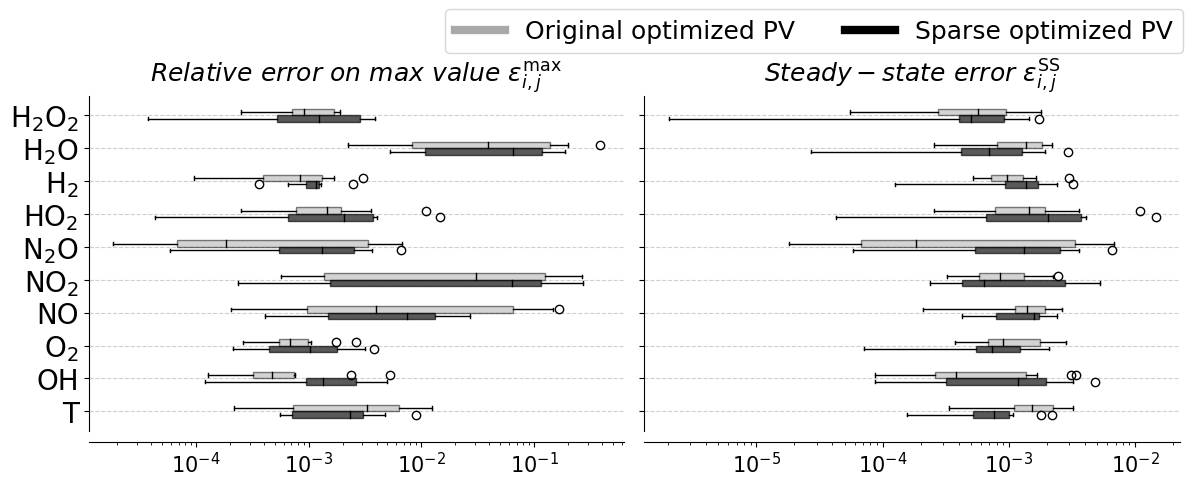

In [22]:
save = True
name = "Figure Suppl Mat - Boxplots max and SS error - ANN a posteriori 0D - complete vs sparse optimized PV.png"
namePdf = "Figure Suppl Mat - Boxplots max and SS error - ANN a posteriori 0D - complete vs sparse optimized PV.pdf"
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/Sparse/Sparse-vs-complete-optimized/"

# --- Prepare data ---
qois = list(results.keys())
n_qoi = len(qois)

# Collect errors in the order of QoIs
SS_opt_complete = [errors_last_optimized_complete[qoi] for qoi in qois]
SS_opt_sparse = [errors_last_optimized_sparse[qoi] for qoi in qois]
max_opt_complete   = [errors_max_optimized_complete[qoi] for qoi in qois]
max_opt_sparse   = [errors_max_optimized_sparse[qoi] for qoi in qois]

# Positions for horizontal boxplots
y_pos = np.arange(n_qoi)
width = 0.2  # distance between boxes

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)

# --- Left subplot: Last error ---
for i in range(n_qoi):
    axes[0].boxplot(max_opt_complete[i], positions=[y_pos[i] + width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='darkgrey', alpha=0.5),
                    medianprops=dict(color='black'))
    axes[0].boxplot(max_opt_sparse[i], positions=[y_pos[i] - width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='black', alpha=0.65),
                    medianprops=dict(color='black'))

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(qois)
axes[0].set_title(r"$\mathit{Relative\ error\ on\ max\ value}\ \varepsilon^{\max}_{i,j}$", fontsize = 18)
axes[0].set_xscale("log")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# --- Right subplot: Steady-state error ---
for i in range(n_qoi):
    axes[1].boxplot(SS_opt_complete[i], positions=[y_pos[i] + width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='darkgrey', alpha=0.5),
                    medianprops=dict(color='black'))
    axes[1].boxplot(SS_opt_sparse[i], positions=[y_pos[i] - width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='black', alpha=0.65),
                    medianprops=dict(color='black'))

axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([q.replace("2", "$_2$") for q in qois[::-1]])
axes[1].set_title(r"$\mathit{Steady-state\ error}\ \varepsilon^{\mathrm{SS}}_{i,j}$", fontsize = 18)
axes[1].set_xscale("log")
axes[0].tick_params(axis='both', labelsize=20)  # y-tick labels
axes[0].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

for i in range(len(axes)):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

offset = 8

axes[0].spines['bottom'].set_position(('outward', offset))
axes[1].spines['bottom'].set_position(('outward', offset))

# --- Legend ---
handles = [
    mlines.Line2D([0], [0], color='darkgrey', lw=6),
    mlines.Line2D([0], [0], color='black', lw=6)
]

labels = ['Original optimized PV', 'Sparse optimized PV']

# Add legend to the figure (not tied to any subplot)
fig.legend(handles, labels, bbox_to_anchor=(1, 1.1), ncol=2, fontsize=18)

plt.tight_layout()
if save:
    plt.savefig(pathSave + name, bbox_inches = "tight", dpi = 300)
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()